In [1]:

#!!!!! qu'est ce qui est nécessaire ???
import os
#import scipy
import numpy as np
import pandas as pd
#import netCDF4 as nc
import matplotlib.pyplot as plt
import sys
#import skimage
from functools import reduce


#from sklearn.cross_decomposition import PLSRegression, PLSCanonical, CCA
#from sklearn.decomposition import PCA

#from sklearn.cluster import FeatureAgglomeration
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import cross_validate, RepeatedKFold


sys.path.append('../functions/')
from functions import load_lat_lon_area, display_map, reverse_mask #, compute_y, display_y


# !!!!!!!!!

In [2]:

#!!!!! qu'est ce qui est nécessaire ???

#from muchos_functions import compute_trend_3d_data, get_biggest_connected_component, construct_matrix_from_subgraph, assign_weight_to_cluster_variables, seuillage_correlation_matrix, display_map, fill_signal, smooth_data, reverse_mask, construct_connectivity_matrix_3d, construct_smooth_connectivity_matrix_3d

#from functions_causality import correlation_glissante, compute_ttest_pvalue
#from lagged_trend import compute_lagged_trend_per_model

#from method_C import compute_correlation_per_cellPattern, compute_weights_smooth_PLS, recover_cells_in_pattern_near_cell

#from load_tos_dos_sos_AMOC import load_multiple_var
#from temporal_metrics import compute_temporal_metrics

#from method_C_clustering import clustering_based_on_connectivity, compute_labels_given_n_clusters, construct_dictionnary_from_clustering, compute_correlation_per_region, select_N_most_correlated_components, method_C_k_components, method_C_k_components_multipleVar

#from load_tos_dos_sos_AMOC import load_tos_dos_sos_AMOC, load_data_given_metric

# !!!!!!!!!


In [3]:


def nanaverage(data, weights=None, axis=None):
    
    masked_data = np.ma.masked_array(data, np.isnan(data))

    average = np.ma.average(masked_data, axis=axis, weights=weights)
    result = average.filled(np.nan)
    return result

def nanstd(data, weights=None, axis=None):
    
    masked_data = np.ma.masked_array(data, np.isnan(data))

    average = np.ma.average(masked_data, axis=axis, weights=weights)
    result = average.filled(np.nan)
    std = np.sqrt(np.ma.average((data-average)**2, axis=axis, weights=weights))
    return std

In [4]:
latitudes, longitudes, area_perLat_per_Lon = load_lat_lon_area("../data/area_r360x180.nc")
longitudes[longitudes>180] -= 360

# Choices of X and Y 

In [5]:
scenario   = "ssp245" # ssp126, ssp245 ou ssp585

#------- Y
anomalie_Y = False
min_Y      = 2091
max_Y      = 2100
min_Y_ref  = 1850
max_Y_ref  = 1900

#------- X
X_choice = "mean" # mean, trend
min_X    = 1900 # 1900 or 1975 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
max_X    = 2020

#------- X en multivarié : est ce qu'on inclue l'AMOC passé en plus des 18 features ?
include_AMOC_in_predictors=True

# Import TOS and SOS runs

In [6]:
list_name_per_var = ["tos", "sos"]

In [7]:
nb_var = len(list_name_per_var)
data_perVar           = []
name_run_perVar       = []
name_models_perVar    = []
name_institute_perVar = []
name_samples_perVar   = []


for var in list_name_per_var:
    data = np.load("../data/multiruns/"+"timeserie_"+var+"_"+scenario+"/data_perSample_perBox_perYear.npy")
    name_runs = np.load("../data/multiruns/"+"timeserie_"+var+"_"+scenario+"/name_run_perSample.npy")
    name_models = np.load("../data/multiruns/"+"timeserie_"+var+"_"+scenario+"/name_model_perSample.npy")
    name_institutes = np.load("../data/multiruns/"+"timeserie_"+var+"_"+scenario+"/name_institute_perSample.npy")
    nb_samples = len(name_runs)
    name_samples = [name_models[id_sample]+"_"+name_runs[id_sample] for id_sample in range(nb_samples)]
    data_perVar.append(data)
    name_run_perVar.append(name_runs)
    name_models_perVar.append(name_models)
    name_institute_perVar.append(name_institutes)
    name_samples_perVar.append(name_samples)
    (nb_samples, nb_box, nb_years) = data.shape
    
                                 


In [8]:
# Check if the times are corrects
final_years = np.arange(1850, 2100+1)
if len(final_years)!=nb_years:
    raise NameError('pb')

In [9]:
# Keep only the common model's runs 
name_samples_X = reduce(np.intersect1d, name_samples_perVar)

X_simu_perSample_perYear_perFeature_bis = np.zeros((len(name_samples_X), nb_years, nb_box*nb_var))

id_feature = 0
for id_box in range(nb_box):
    for id_var in range(nb_var):
        _, id_samples_out, id_samples_in = np.intersect1d(name_samples_X, name_samples_perVar[id_var], return_indices=True)

        X_simu_perSample_perYear_perFeature_bis[id_samples_out, :, id_feature] = data_perVar[id_var][id_samples_in, id_box, :]
        id_feature += 1
        
        

In [10]:
X_simu_perSample_perYear_perFeature_bis.shape

(204, 251, 18)

# Import AMOC runs

In [11]:
metric = "AMOC"

hist_times            = np.load("../data/multiruns/"+"historical"+"_"+metric+"_"+scenario+"/times.npy").astype(str).astype(int)
name_model_per_sample = np.load("../data/multiruns/"+"historical"+"_"+metric+"_"+scenario+"/name_model_per_model.npy")
name_run_per_sample   = np.load("../data/multiruns/"+"historical"+"_"+metric+"_"+scenario+"/name_run_per_model.npy")
nb_times              = len(hist_times)
nb_samples            = len(name_model_per_sample)
hist_name_samples     = [name_model_per_sample[id_sample]+"_"+name_run_per_sample[id_sample] for id_sample in range(nb_samples)]
hist_AMOC = np.memmap("../data/multiruns/"+"historical"+"_"+metric+"_"+scenario+"/data.dat", dtype='float32', mode='r+',
                              shape=(nb_samples, nb_times))

period                = scenario
ssp_times             = np.load("../data/multiruns/"+period+"_"+metric+"/times.npy").astype(str).astype(int)
name_model_per_sample = np.load("../data/multiruns/"+period+"_"+metric+"/name_model_per_model.npy")
name_run_per_sample   = np.load("../data/multiruns/"+period+"_"+metric+"/name_run_per_model.npy")
nb_times              = len(ssp_times)
nb_samples            = len(name_model_per_sample)
ssp245_name_samples   = [name_model_per_sample[id_sample]+"_"+name_run_per_sample[id_sample] for id_sample in range(nb_samples)]
ssp245_AMOC = np.memmap("../data/multiruns/"+period+"_"+metric+"/data.dat", dtype='float32', mode='r+',
                              shape=(nb_samples, nb_times))


## Example of an AMOC run

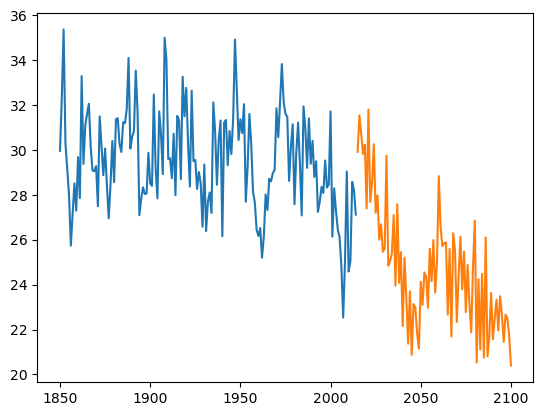

In [12]:
name_run = ssp245_name_samples[5]
plt.plot(hist_times, hist_AMOC[np.array(hist_name_samples)==name_run][0])

plt.plot(ssp_times, ssp245_AMOC[np.array(ssp245_name_samples)==name_run][0])

# Select only the run that are available for both TOS, SOS and AMOC

In [13]:
# Select only the run that are available for both TOS, SOS and AMOC
final_name_samples = reduce(np.intersect1d, [name_samples_X, hist_name_samples, ssp245_name_samples])

_, out_id_samples_X, in_id_samples_X       = np.intersect1d(final_name_samples, name_samples_X, return_indices=True)
_, out_id_samples_hist, in_id_samples_hist = np.intersect1d(final_name_samples, hist_name_samples, return_indices=True)
_, out_id_samples_ssp, in_id_samples_ssp   = np.intersect1d(final_name_samples, ssp245_name_samples, return_indices=True)

X_simu_perSample_perYear_perFeature        = X_simu_perSample_perYear_perFeature_bis[in_id_samples_X]

# Select only the times common between TOS, SOS and AMOC
_, out_id_times_hist, in_id_times_hist = np.intersect1d(final_years, hist_times, return_indices=True)
_, out_id_times_ssp, in_id_times_ssp   = np.intersect1d(final_years, ssp_times, return_indices=True)

AMOC = np.nan*np.zeros((len(final_name_samples), len(final_years)))
AMOC[:, out_id_times_hist] = np.copy(hist_AMOC[in_id_samples_hist][:, in_id_times_hist])
# this is made possible by the fact that out_id_samples_hist is sorted
AMOC[:, out_id_times_ssp]   = np.copy(ssp245_AMOC[in_id_samples_ssp][:, in_id_times_ssp])
Y = np.copy(AMOC)
times_Y = np.copy(final_years)

# Find the number of run given by each climate models

In [14]:
nb_samples = len(final_name_samples)

final_name_models = [final_name_samples[id_sample].split('_r')[0] for id_sample in range(nb_samples)]

unique_models, counter = np.unique(final_name_models, return_counts=True)

final_weight_per_sample = np.nan*np.zeros(nb_samples)
for id_sample in range(nb_samples):
    nb_runs = counter[final_name_models[id_sample]==unique_models][0]
    final_weight_per_sample[id_sample] = 1/nb_runs
    

In [15]:
final_name_samples.shape

(201,)

In [16]:
data = np.concatenate((unique_models.reshape(-1,1), counter.reshape(-1,1)), axis=1)
df = pd.DataFrame(data, columns=["name model", "number of runs"], index=np.arange(1,len(data)+1))
df

,name model,number of runs
1,ACCESS-CM2,3
2,ACCESS-ESM1-5,30
3,CAS-ESM2-0,2
4,CESM2,3
5,CESM2-WACCM,3
6,CIESM,1
7,CMCC-CM2-SR5,1
8,CMCC-ESM2,1
9,CNRM-CM6-1,6
10,CNRM-CM6-1-HR,1


In [17]:
print("numer of climate models : {}".format(int(np.sum(final_weight_per_sample))))

numer of climate models : 33


# Import AMOC observations

In [18]:
path          = "../data/last_obs_AMOC/moc_transports.mat"
import scipy.io
mat = scipy.io.loadmat(path)

obs_AMOC_times_days = mat['JG'][0]
obs_AMOC_times_days = obs_AMOC_times_days.astype("datetime64[D]")-np.datetime64('1970-01-01')+np.datetime64('2004-04-01')
obs_AMOC_times_years = obs_AMOC_times_days.astype("datetime64[Y]")
AMOC_days = mat['MOC_mar_hc10'][0,:]

#np.linspace(np.datetime64('2004'), np.datetime64('2021'))

mean_AMOC_perYear = []
years_to_mean = np.arange(0,21).astype("datetime64[Y]")-np.datetime64('1970')+np.datetime64('2004')
for year in years_to_mean:
    id_days = obs_AMOC_times_years==year
    sub_AMOC_days = AMOC_days[id_days]
    sub_AMOC_days = sub_AMOC_days[sub_AMOC_days>-99999.]
    mean_AMOC_perYear.append(np.mean(sub_AMOC_days))
    
obs_AMOC_times  = np.array(years_to_mean).astype(str).astype(int)
obs_AMOC_values = np.array(mean_AMOC_perYear)

C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


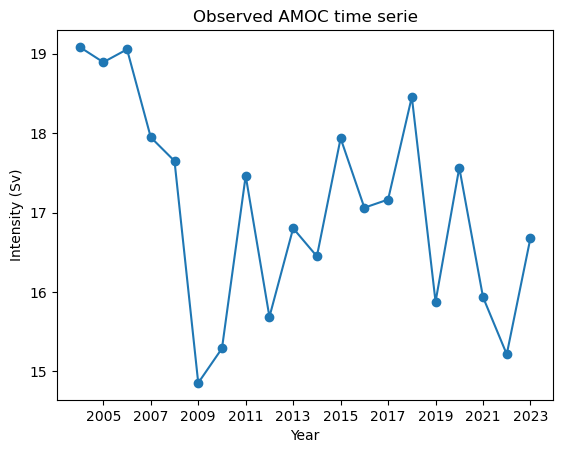

In [19]:
plt.scatter(obs_AMOC_times, obs_AMOC_values)
plt.plot(obs_AMOC_times, obs_AMOC_values)
plt.xticks(obs_AMOC_times[1::2])
plt.title("Observed AMOC time serie")
plt.ylabel("Intensity (Sv)")
plt.xlabel("Year")
plt.show()

# Transform the AMOC time series into a single feature (mean 2005-2021)

In [20]:
min_X_AMOC = 2005
max_X_AMOC = 2023

times_to_mean  = np.logical_and(final_years>=min_X_AMOC, final_years<=max_X_AMOC)
times_obs_AMOC = np.logical_and(obs_AMOC_times<=max_X_AMOC, obs_AMOC_times>=min_X_AMOC)

# name_X 
if X_choice=="mean":
    X_simu_AMOC = np.nanmean(Y[:, times_to_mean], axis=1)
    X_obs_AMOC  = np.mean(obs_AMOC_values[times_obs_AMOC])
    name_X_AMOC = "mean AMOC {}-{}".format(min_X_AMOC, max_X_AMOC)
    
elif X_choice=="trend":
    nb_years    = len(times_Y[times_to_mean])
    nb_models   = len(Y)
    X_simu_AMOC = compute_trend_3d_data(Y[:, times_to_mean].reshape((nb_models, nb_years, 1)),
                            times_Y[times_to_mean])[:, 0]
    name_X_AMOC = "trend AMOC {}-{}".format(min_X_AMOC, max_X_AMOC)
    nb_years = len(obs_AMOC_times[times_obs_AMOC])
    X_obs_AMOC  = compute_trend_3d_data(obs_AMOC_values[times_obs_AMOC].reshape((1, nb_years, 1)),
                            obs_AMOC_times[times_obs_AMOC])[0, 0]
    
    
X_AMOC_mean_1850_1900 = np.nanmean(Y[:,
                        np.logical_and(times_Y>=1850, times_Y<=1900)], axis=1)




In [21]:
np.mean(X_AMOC_mean_1850_1900), np.std(X_AMOC_mean_1850_1900)

(16.263174480862087, 4.537533258052238)

In [22]:
print("Mean {}-{} AMOC (RAPID) is {:.2f} Sv.".format(min_X_AMOC, max_X_AMOC, X_obs_AMOC))


Mean 2005-2023 AMOC (RAPID) is 16.95 Sv.


# Import TOS and SOS observations

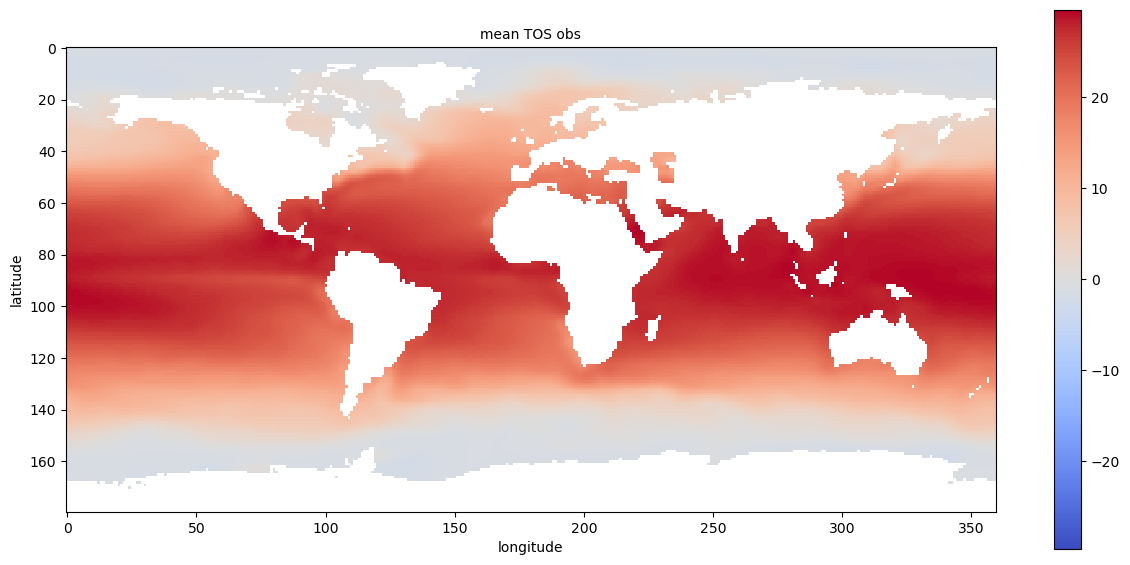

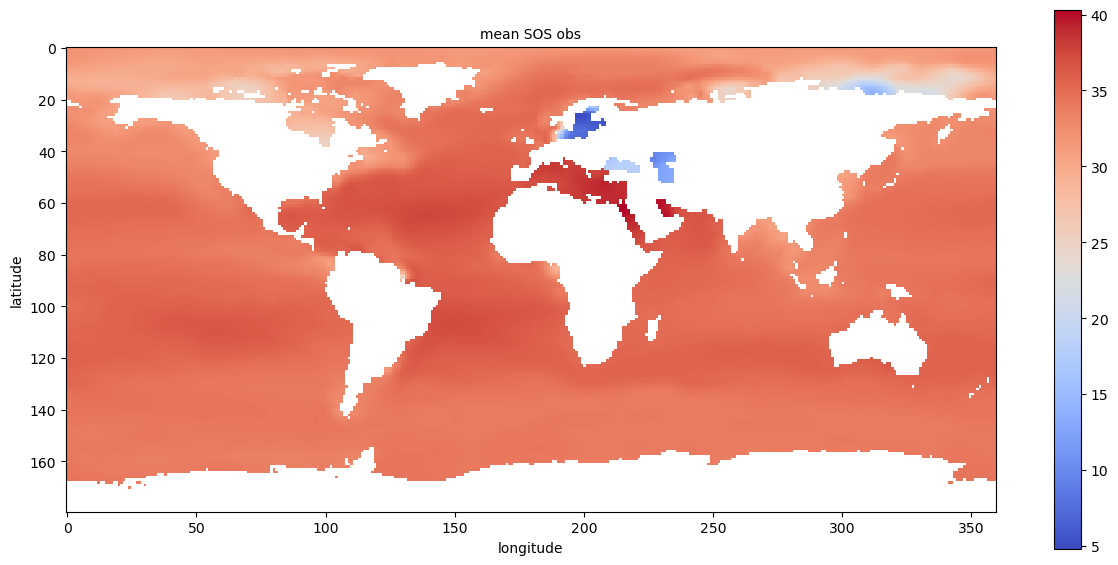

In [23]:
obs_tos_times = np.load("../data/obs_SST_SSS/times.npy")
obs_sos_times = obs_tos_times

# Masques
obs_tos_mask = np.load("../data/obs_SST_SSS/mask_tos_obs.npy")
obs_sos_mask = np.load("../data/obs_SST_SSS/mask_sos_obs.npy")

# Données masquées
obs_tos_perYear_perCell     = np.load("../data/obs_SST_SSS/masked_tos_obs.npy")
obs_sos_perYear_perCell     = np.load("../data/obs_SST_SSS/masked_sos_obs.npy")
var_obs_tos_perYear_perCell = np.load("../data/obs_SST_SSS/masked_tos_obs_var.npy")
var_obs_sos_perYear_perCell = np.load("../data/obs_SST_SSS/masked_sos_obs_var.npy")


#------------------------------------------------------------ Affichage
mean_obs_tos_perCell = np.mean(obs_tos_perYear_perCell, axis=0)
mean_obs_sos_perCell = np.mean(obs_sos_perYear_perCell, axis=0)
mM = np.max(np.abs(mean_obs_tos_perCell))
display_map(mean_obs_tos_perCell, obs_tos_mask, title="mean TOS obs", cmap='coolwarm',
            vmin=-mM, vmax=mM)
plt.show()

display_map(mean_obs_sos_perCell, obs_sos_mask, title="mean SOS obs", cmap='coolwarm')
plt.show()


In [24]:
ObsData_mask_perVar            = [obs_tos_mask, obs_sos_mask]
ObsData_perVar_perYear_perCell = [obs_tos_perYear_perCell, obs_sos_perYear_perCell]
ObsVar_perVar_perYear_perCell  = [var_obs_tos_perYear_perCell, var_obs_sos_perYear_perCell]
ObsTimes_perVar                = [obs_tos_times, obs_sos_times]

In [25]:
obs_tos_times

array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022])

# Pooling the spatial masks and the times

In [26]:
obs_times = np.arange(1900, 2022+1)

In [27]:
mask_perVar  = []
Times_perVar = []

ObsData_perVar_perYear_perCell_ = [
    np.nan*np.zeros((len(obs_times), np.sum(ObsData_mask_perVar[id_var]))) for id_var in range(nb_var)]
ObsVar_perVar_perYear_perCell_ = [
    np.nan*np.zeros((len(obs_times), np.sum(ObsData_mask_perVar[id_var]))) for id_var in range(nb_var)]

for id_var in range(nb_var):
    
    #-------------- Find the shared spatial mask 
    mask_obs           = ObsData_mask_perVar[id_var]
    mask_perVar.append(mask_obs)
    
    #-------------- Find the shared times
    times, times_id_out_obs, times_id_in_obs   = np.intersect1d(obs_times, ObsTimes_perVar[id_var], return_indices=True)
    times, times_id_out_simu, times_id_in_simu = np.intersect1d(obs_times, final_years, return_indices=True)
    Times_perVar.append(times)
    
    #-------------- Storage of the intersection   
    ObsData_perVar_perYear_perCell_[id_var][times_id_out_obs] = ObsData_perVar_perYear_perCell[id_var][times_id_in_obs]
    ObsVar_perVar_perYear_perCell_[id_var][times_id_out_obs] = ObsVar_perVar_perYear_perCell[id_var][times_id_in_obs]


    

# Definition of the spatial regions

In [28]:
lonlat_lim_perBox = [[-30, 30, 65, 80],
                     [-70, -35, 45, 65],
                     [-40, 0, 45, 65],
                     [-90, 0, 15, 45],
                     [-70, 10, 0, 15],
                     [-50, 20, -15, 0],
                     [-60, 20, -40, -15],
                     [30, 110, -30, 20],
                     [-130, -90, -10, 10]]

name_perBox = ["Nordic Seas", "Labrador", "Subpolar\nEast", "Subtropical",
               "Tropical North", "Tropical South", "Atlantic South", "Indian Ocean", "Nino"]

nb_box = len(name_perBox)
if nb_box!= len(lonlat_lim_perBox):
    print("issue !")
    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors_perBox = prop_cycle.by_key()['color'][:nb_box]

# Averaging for each region

In [29]:

nb_times = len(obs_times)
X_obs_perYear_perFeature           = np.nan*np.zeros((nb_times, nb_var*nb_box))
X_obsVar_perYear_perFeature        = np.nan*np.zeros((nb_times, nb_var*nb_box))

id_feature = 0
list_id_box_perFeature = []
list_id_var_perFeature = []
list_idCell_perFeature = []
middle_cell_perBox     = []
list_name_perFeature   = []
for id_box in range(nb_box):
    minLon, maxLon, minLat, maxLat = lonlat_lim_perBox[id_box]
    middle_cell_perBox.append([(minLon+maxLon)/2, (minLat+maxLat)/2])
    
    lon_to_keep = np.logical_and(longitudes>=minLon, longitudes<=maxLon)
    lat_to_keep = np.logical_and(latitudes>=minLat, latitudes<=maxLat)
    
    for id_var in range(nb_var):
        # Sélection des cellules correspondant à la zone
        ObsData_perYear_perCell_           = ObsData_perVar_perYear_perCell_[id_var]
        ObsVar_perYear_perCell_            = ObsVar_perVar_perYear_perCell_[id_var]
        
        mask_common = mask_perVar[id_var]
        idCells_to_keep = np.matmul(lat_to_keep.reshape(-1,1), lon_to_keep.reshape(1,-1))[mask_common]
        
        mask_region = np.logical_and(np.matmul(lat_to_keep.reshape(-1,1), lon_to_keep.reshape(1,-1)), mask_common)
        areas = area_perLat_per_Lon[mask_region]
        print("{} cells".format(np.sum(mask_region)))
        
        # Stockage (Moyennage spatial sur la zone)
        #X_simu_perSample_perYear_perFeature_bis[:, :, id_feature] = np.average(
        #                                      Simu_perSample_perYear_perFeature[:, :, idCells_to_keep],
        #                                      weights=areas, axis=2)
        
        X_obs_perYear_perFeature[:, id_feature] = np.average(
                                              ObsData_perYear_perCell_[:, idCells_to_keep],
                                              weights=areas, axis=1)
        
        # Variance de la somme (indépendance spatiale) = (somme variances)/N² = (moyenne)/N
        X_obsVar_perYear_perFeature[:, id_feature] = np.average(
                                              ObsVar_perYear_perCell_[:, idCells_to_keep],
                                              weights=areas, axis=1)/len(idCells_to_keep)
        
        list_id_box_perFeature.append(id_box)
        list_id_var_perFeature.append(id_var)
        list_idCell_perFeature.append(idCells_to_keep)
        list_name_perFeature.append("{} {}".format(list_name_per_var[id_var], name_perBox[id_box]))
        id_feature += 1
        


792 cells
792 cells
601 cells
601 cells
801 cells
801 cells
2207 cells
2207 cells
850 cells
850 cells
788 cells
788 cells
1663 cells
1663 cells
3332 cells
3332 cells
820 cells
820 cells


In [30]:
X_simu_perSample_perYear_perFeature.shape

(201, 251, 18)

In [31]:
X_obs_perYear_perFeature.shape

(123, 18)

# Display the time serie feature (SST or SSS for one region) per feature

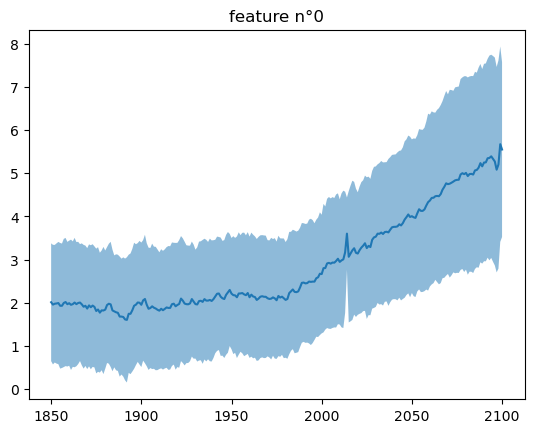

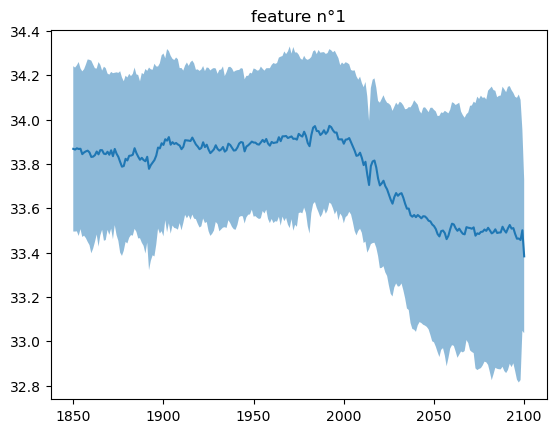

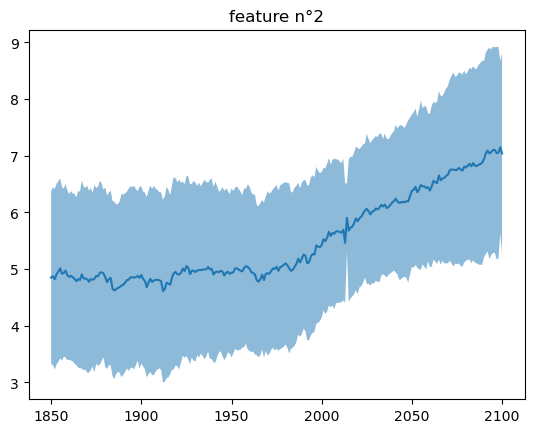

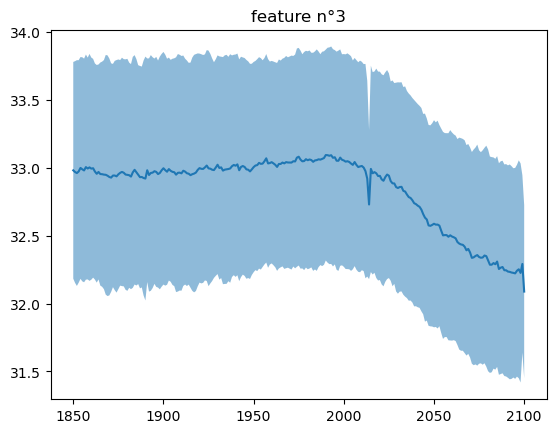

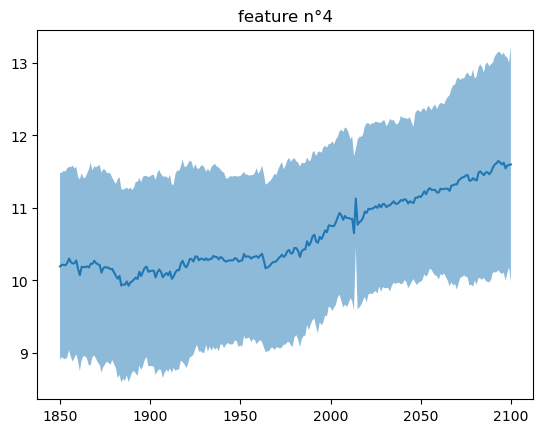

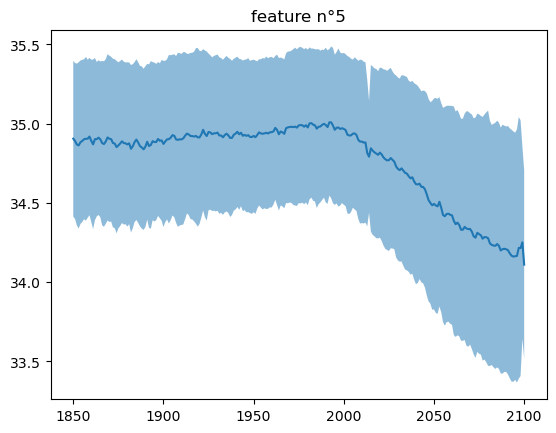

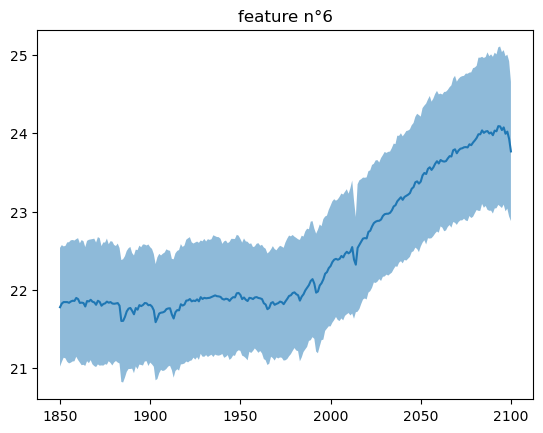

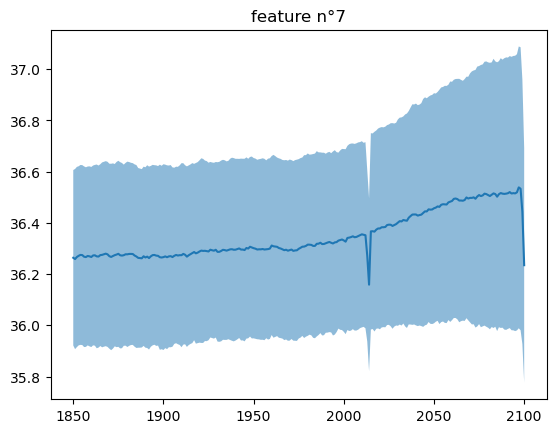

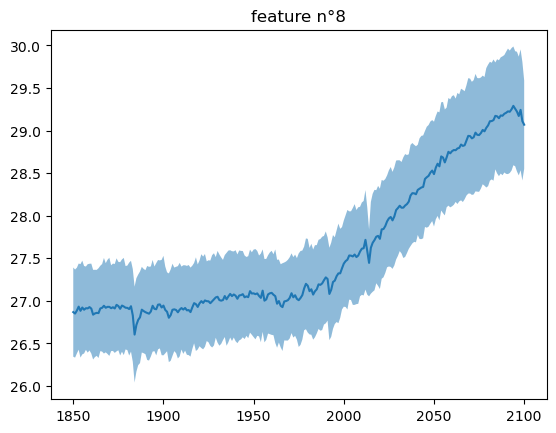

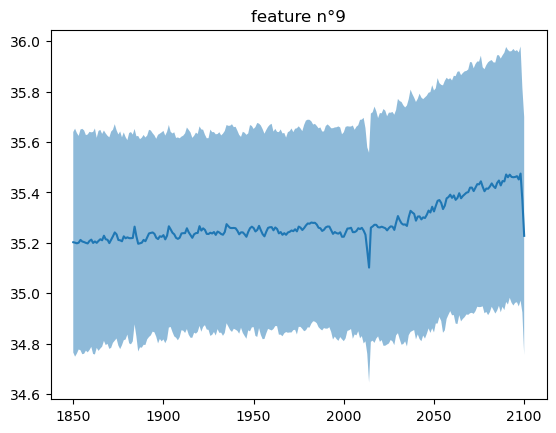

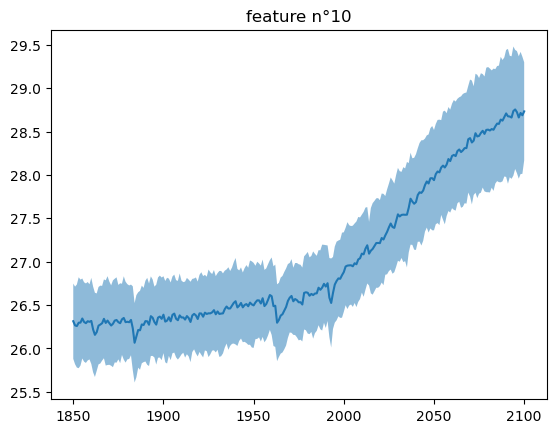

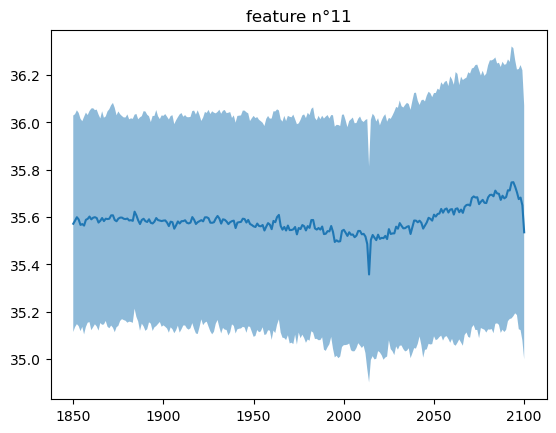

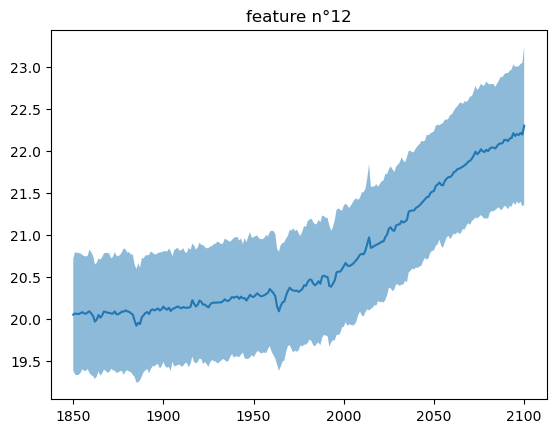

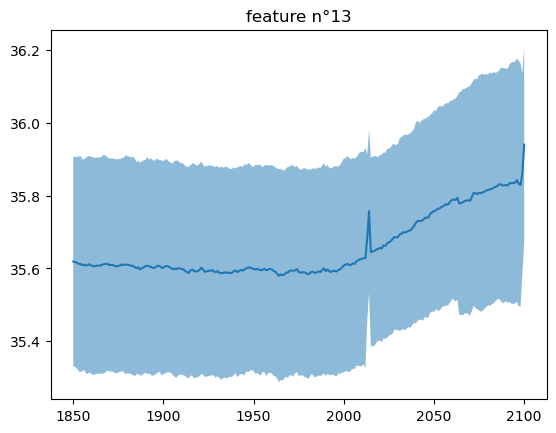

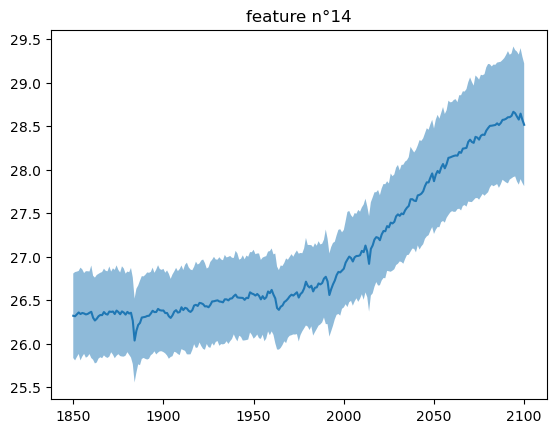

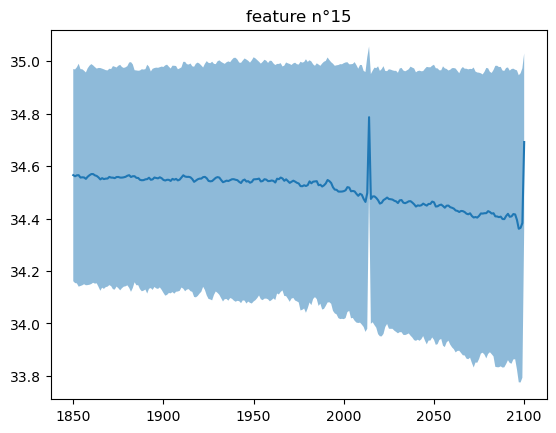

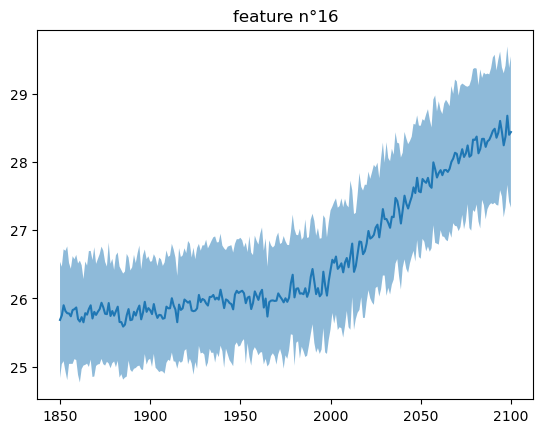

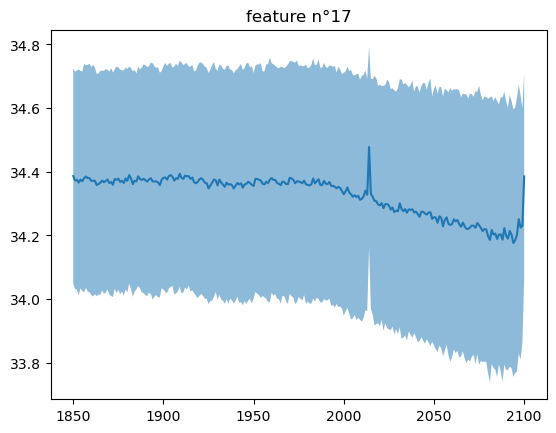

In [32]:
(nb_samples, nb_times, nb_features) = X_simu_perSample_perYear_perFeature.shape
for id_feature in range(nb_features):
    plt.figure()
    #plt.subplot(nb_features, 1, id_feature+1)
    
    mean_multi_model = nanaverage(X_simu_perSample_perYear_perFeature[:, :, id_feature], axis=0, weights=final_weight_per_sample)
    std_multi_model = nanstd(X_simu_perSample_perYear_perFeature[:, :, id_feature], axis=0, weights=final_weight_per_sample)
    plt.plot(final_years, mean_multi_model)
    plt.fill_between(final_years, mean_multi_model-std_multi_model, mean_multi_model+std_multi_model, alpha=0.5)
    plt.title("feature n°{}".format(id_feature))
    plt.show()

# Example of two different runs, for the same region, compared to the observations

Text(0, 0.5, 'sos Nordic Seas')

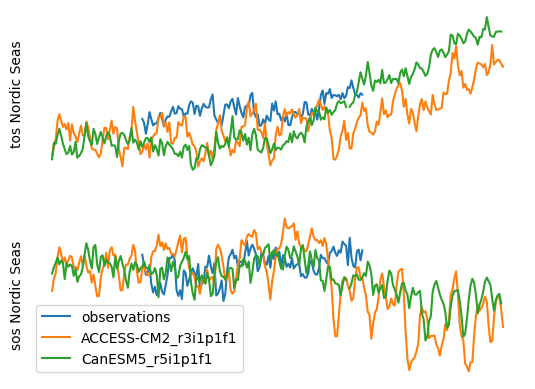

In [33]:
id_feature = 0
id_model_1 = 2
id_model_2 = 100

plt.subplot(211)
plt.box(False)
plt.plot(obs_times, X_obs_perYear_perFeature[:, id_feature], label="observations")
plt.plot(final_years, X_simu_perSample_perYear_perFeature[id_model_1, :, id_feature], label=final_name_samples[id_model_1])
plt.plot(final_years, X_simu_perSample_perYear_perFeature[id_model_2, :, id_feature], label=final_name_samples[id_model_2])
#plt.legend()
plt.xticks([])
plt.yticks([])
plt.ylabel("{}".format(list_name_perFeature[id_feature]))

plt.subplot(212)
plt.box(False)
plt.plot(obs_times, X_obs_perYear_perFeature[:, id_feature+1], label="observations")
plt.plot(final_years, X_simu_perSample_perYear_perFeature[id_model_1, :, id_feature+1], label=final_name_samples[id_model_1])
plt.plot(final_years, X_simu_perSample_perYear_perFeature[id_model_2, :, id_feature+1], label=final_name_samples[id_model_2])
plt.legend()
plt.xticks([])
plt.yticks([])
plt.ylabel("{}".format(list_name_perFeature[id_feature+1]))


# Figure S1: Display the regions

In [34]:
mask           = mask_perVar[0]
nb_cells       = np.sum(mask)
id_box_perCell = nb_box*np.ones(nb_cells, dtype=int)

for id_feature in range(nb_features):
    if list_id_var_perFeature[id_feature]==0:
        id_cells = list_idCell_perFeature[id_feature]
        id_box   = list_id_box_perFeature[id_feature]
        id_box_perCell[id_cells] = id_box


In [35]:
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("cmap_name", colors_perBox+['#D3D3D3'], N=nb_box+1)

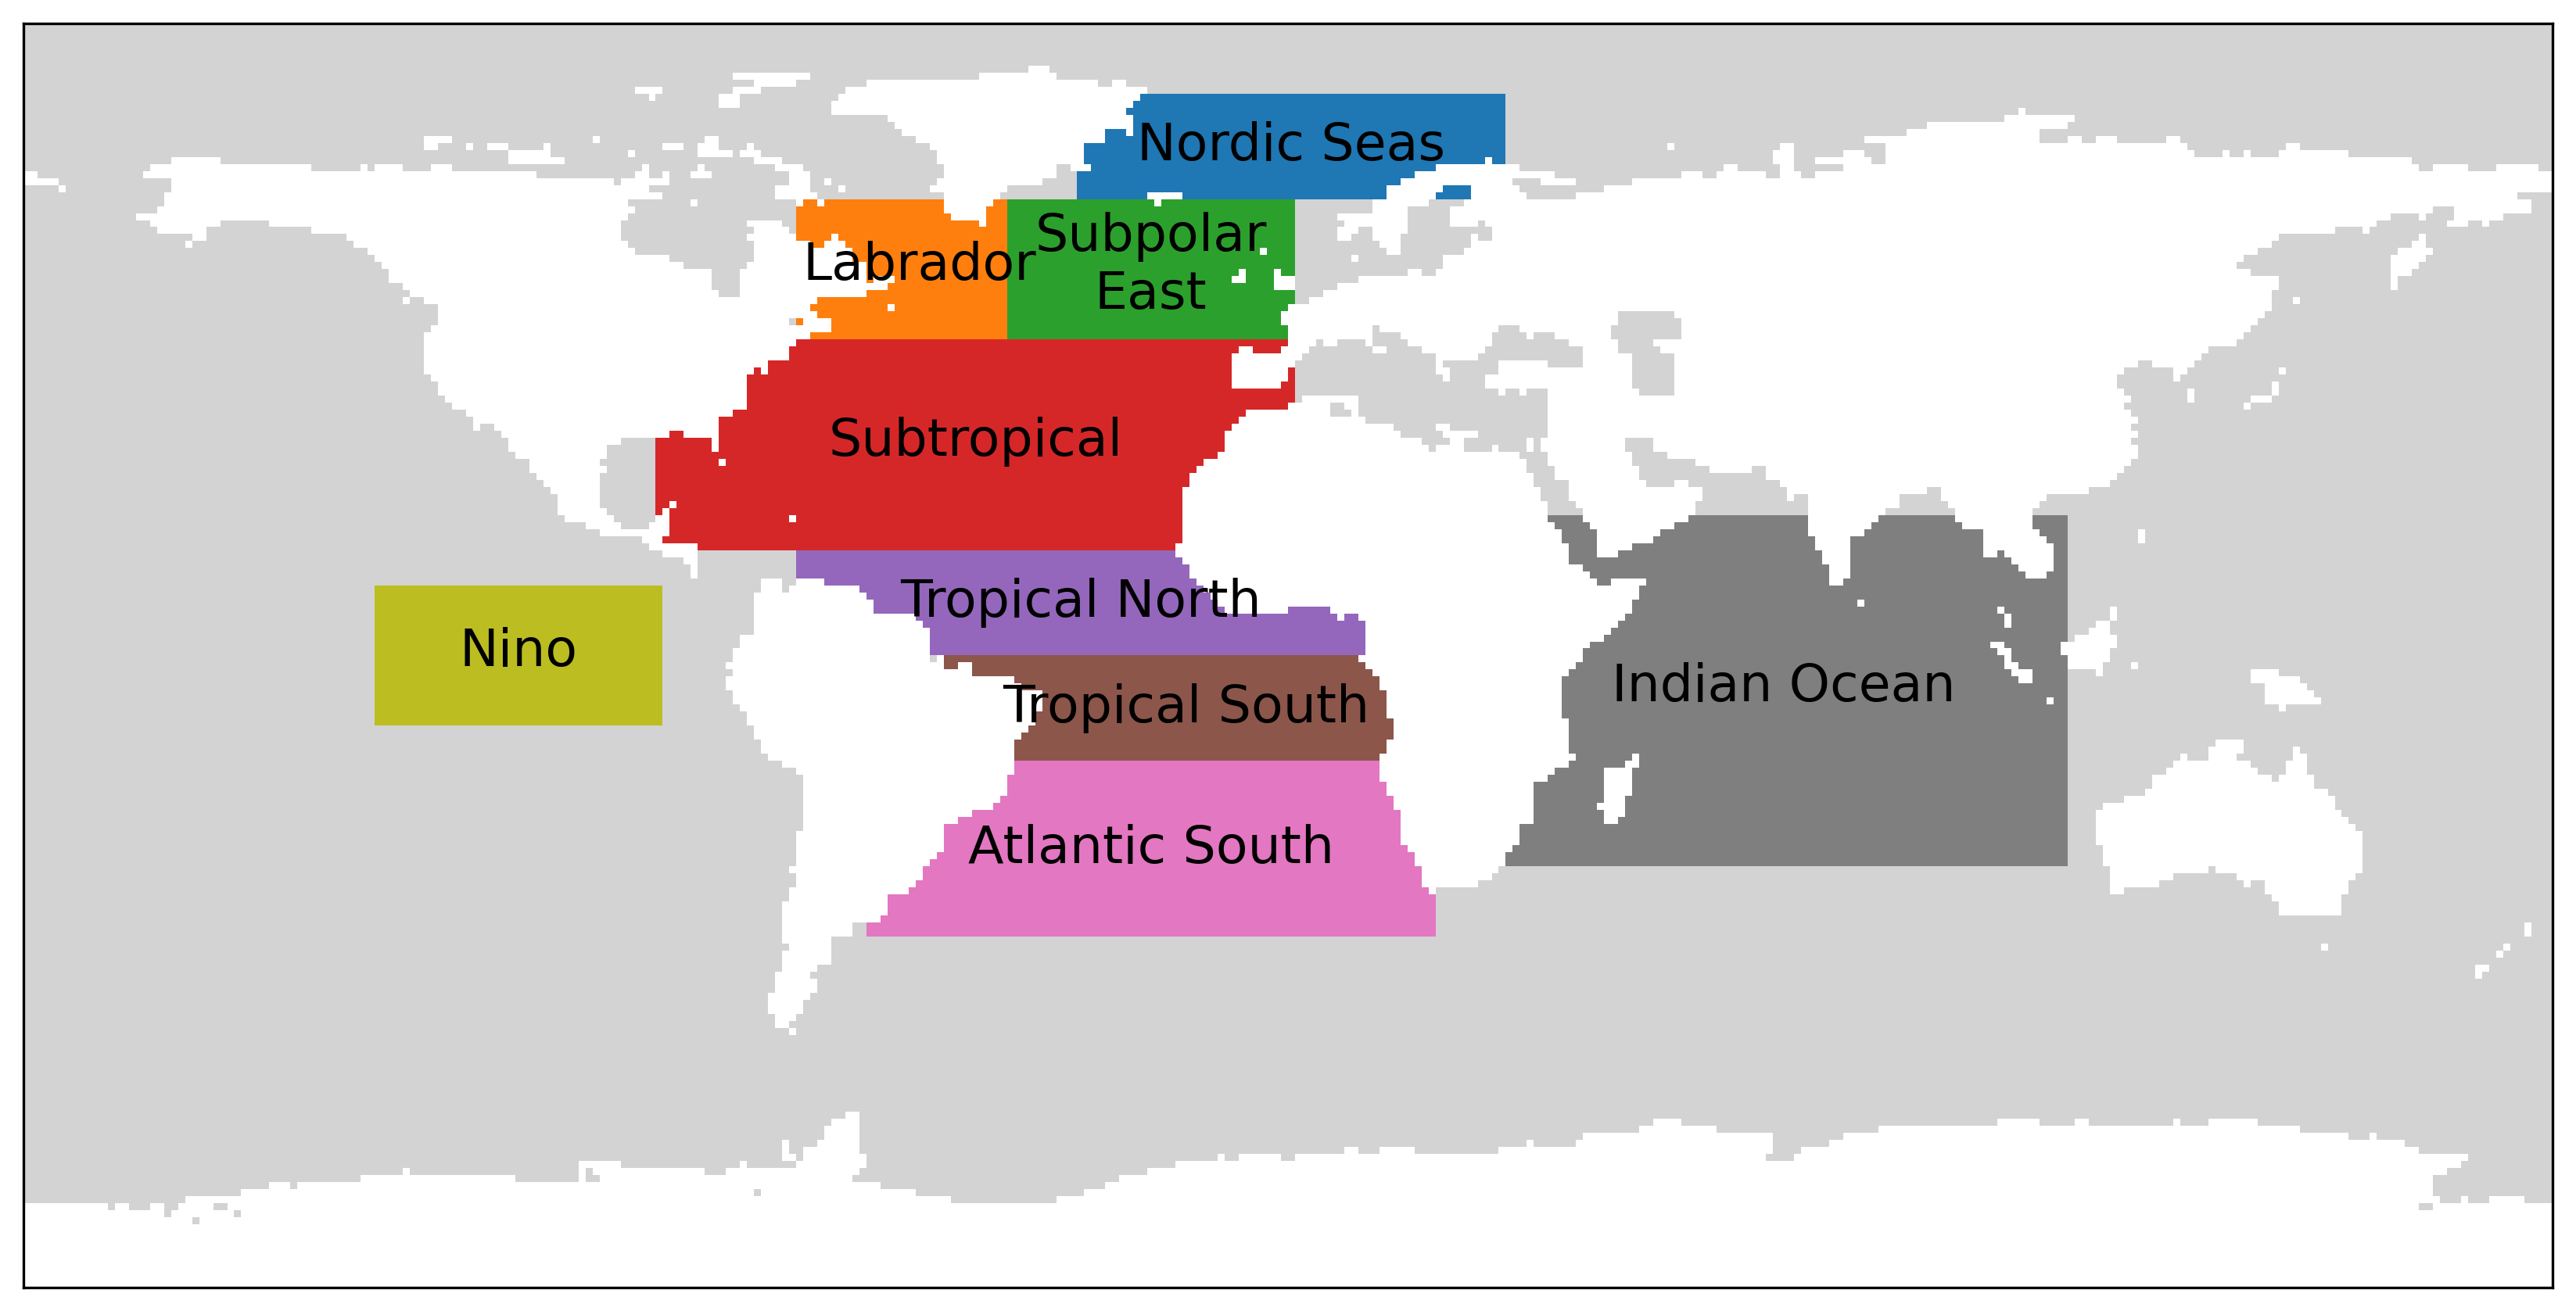

In [36]:
map_coefs = reverse_mask(id_box_perCell, np.logical_not(mask))
nb_lat, nb_lon = map_coefs.shape

flipped_image      = np.flip(map_coefs, axis=0)
flipped_latitudes  = np.flip(latitudes)
translate_image    = np.concatenate((flipped_image[:, nb_lon//2:nb_lon], flipped_image[:, 0:nb_lon//2]), axis=1)
flipped_longitudes = np.concatenate((longitudes[nb_lon//2:nb_lon], longitudes[0:nb_lon//2])).astype(int)


plt.figure(figsize=(15,7), dpi=300)
plt.imshow(translate_image, interpolation='none', cmap=cmap)
plt.xticks(ticks=np.arange(len(longitudes))[::20], labels=flipped_longitudes[::20])
plt.yticks(ticks=np.arange(len(latitudes))[::30], labels=flipped_latitudes[::30])

plt.xticks([])
plt.yticks([])
#plt.ylabel("latitude", fontsize=None)
#plt.xlabel("longitude", fontsize=None)



displayed_lonlat = np.matmul(flipped_longitudes.reshape(-1,1), flipped_latitudes.reshape(1,-1))


for id_feature in range(nb_features):
    if list_id_var_perFeature[id_feature]==0:
        id_cells = list_idCell_perFeature[id_feature]
        id_box   = list_id_box_perFeature[id_feature]
        [middle_lon, middle_lat] = middle_cell_perBox[id_box]
        id_lon = np.argmin(np.abs(flipped_longitudes-middle_lon))
        id_lat = np.argmin(np.abs(flipped_latitudes-middle_lat))
        
        plt.text(id_lon, id_lat, name_perBox[id_box], ha='center',va='center',
                 color='black', fontsize=16)#, weight="bold")

#plt.title("Definition of spatial regions", fontsize=18)#, weight="bold")
plt.show()

# Definition of the features constructed from TOS and SOS, as time-means or time-trends

In [37]:
obs_times_to_keep = np.logical_and(min_X<=obs_times, obs_times<=max_X)
simu_times_to_keep = np.logical_and(min_X<=final_years, final_years<=max_X)
times    = final_years[simu_times_to_keep]
nb_years = len(times)


if X_choice=="mean":
    X_obs  = np.nanmean(X_obs_perYear_perFeature[obs_times_to_keep], axis=0)
    X_simu = np.nanmean(X_simu_perSample_perYear_perFeature[:, simu_times_to_keep], axis=1)
elif X_choice=="trend":
    nb_years = len(obs_times[obs_times_to_keep])
    X_obs  = compute_trend_3d_data(X_obs_perYear_perFeature[obs_times_to_keep].T.reshape((nb_features, nb_years, 1)),
                            times)[:, 0]
    X_simu = compute_trend_3d_data(X_simu_perSample_perYear_perFeature[:, simu_times_to_keep],
                            times)




# Definition of Y

In [38]:
times_to_mean = np.logical_and(final_years>=min_Y, final_years<=max_Y)
Y_ref  = nanaverage(Y[:, np.logical_and(final_years>=min_Y_ref, final_years<=max_Y_ref)], axis=1)
if False:
    Y_anom_percent = 100 * (Y_ref.reshape(-1,1)-Y)/Y_ref.reshape(-1,1)
    Y_simu_anom = np.nanmean(Y_anom_percent[:, times_to_mean], axis=1)
else:
    Y_anom  = Y - Y_ref.reshape(-1,1)
    Y_simu_anom = np.nanmean(Y_anom[:, times_to_mean], axis=1)

if anomalie_Y:
    #name_Y = "AMOC slow-down % {}-{}\n(anomalie ref {}-{})".format(min_Y, max_Y, min_Y_ref, max_Y_ref)
    name_Y = "mean AMOC anomaly {}-{}\n(ref {}-{})".format(min_Y, max_Y, min_Y_ref, max_Y_ref)
    Y_simu = Y_simu_anom
else:
    Y_simu = np.nanmean(Y[:, times_to_mean], axis=1)
    name_Y = "mean AMOC {}-{}".format(min_Y, max_Y)

    
print(np.nanmin(Y_ref), np.nanmax(Y_ref), np.nanmean(Y_ref), np.nanstd(Y_ref))
print(np.nanmin(Y_simu_anom), np.nanmax(Y_simu_anom))
print(np.nanmin(Y_simu), np.nanmax(Y_simu), np.nanmean(Y_simu), np.nanstd(Y_simu))

10.5279302036061 29.867625778796626 16.263174480862087 4.537533258052238
-12.441622193654375 -1.1298670114255422
4.32194230556488 22.274098205566407 11.249526218533514 3.2527314586619


C:\Users\vportmann\AppData\Local\Temp\ipykernel_8108\2632134184.py:8: RuntimeWarning: Mean of empty slice
  Y_simu_anom = np.nanmean(Y_anom[:, times_to_mean], axis=1)
C:\Users\vportmann\AppData\Local\Temp\ipykernel_8108\2632134184.py:15: RuntimeWarning: Mean of empty slice
  Y_simu = np.nanmean(Y[:, times_to_mean], axis=1)


# Select only the run without nan values, in Y

In [39]:
model_to_keep = np.logical_not(np.isnan(Y_simu))

Y_ref             = Y_ref[model_to_keep]
Y_simu            = Y_simu[model_to_keep]
X_simu            = X_simu[model_to_keep]
X_simu_AMOC       = X_simu_AMOC[model_to_keep]
final_name_samples = final_name_samples[model_to_keep]
final_name_models  = np.array(final_name_models)[model_to_keep]
X_AMOC_mean_1850_1900   = X_AMOC_mean_1850_1900[model_to_keep]
final_weight_per_sample = final_weight_per_sample[model_to_keep]
final_weight_per_sample /= np.sum(final_weight_per_sample)

np.sum(final_weight_per_sample), len(final_weight_per_sample)


(1.0, 200)

# Concatenate (or not the features of SST and SSS with the AMOC feature)

In [40]:
if include_AMOC_in_predictors:
    X_simu = np.concatenate((X_simu, X_simu_AMOC.reshape(-1,1)), axis=1)
    
    X_obs = np.concatenate((X_obs, X_obs_AMOC.reshape(-1)))
    list_name_perFeature.append(name_X_AMOC)
    list_id_var_perFeature.append(2)

# Average each model on its available members

In [41]:
uniques_models = np.unique(final_name_models)

nb_models   = len(uniques_models)
nb_features = len(X_simu[0])

Y_ref_resampled       = np.nan*np.zeros(nb_models)
Y_simu_resampled      = np.nan*np.zeros(nb_models)
Y_simu_first_run      = np.nan*np.zeros(nb_models)
X_simu_resampled      = np.nan*np.zeros((nb_models, nb_features))
X_simu_first_run      = np.nan*np.zeros((nb_models, nb_features))
X_simu_AMOC_resampled = np.nan*np.zeros(nb_models)
X_AMOC_mean_1850_1900_resampled = np.nan*np.zeros(nb_models)
id_samples_perModel   = []

for id_model in range(nb_models):
    name_model = uniques_models[id_model]
    id_samples_to_average = np.where(final_name_models==name_model)[0]
    id_samples_perModel.append(id_samples_to_average)
    Y_simu_resampled[id_model] = np.mean(Y_simu[id_samples_to_average])
    Y_ref_resampled[id_model]  = np.mean(Y_ref[id_samples_to_average])
    X_simu_resampled[id_model] = np.mean(X_simu[id_samples_to_average], axis=0)
    X_simu_AMOC_resampled[id_model] = np.mean(X_simu_AMOC[id_samples_to_average])
    Y_simu_first_run[id_model] = Y_simu[id_samples_to_average[0]]
    X_simu_first_run[id_model] = X_simu[id_samples_to_average[0]]
    X_AMOC_mean_1850_1900_resampled[id_model] = X_AMOC_mean_1850_1900[id_samples_to_average[0]]


In [42]:
Y_simu.shape, X_simu.shape, X_simu_AMOC.shape, final_name_models.shape, Y_ref_resampled.shape

((200,), (200, 19), (200,), (200,), (32,))

# Display the AMOC runs per model

In [43]:

print(len(final_name_models))
for id_model in range(nb_models):
    name_model = uniques_models[id_model]
    id_samples = np.where(final_name_models==name_model)[0]
    list_name_runs = []
    for id_sample in id_samples:
        sample = final_name_samples[id_sample]
        list_name_runs.append(sample[len(name_model)+1:])
        
    print("{} ({}) : {}\n".format(name_model, len(list_name_runs), list_name_runs))


200
ACCESS-CM2 (3) : ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']

ACCESS-ESM1-5 (30) : ['r10i1p1f1', 'r11i1p1f1', 'r12i1p1f1', 'r13i1p1f1', 'r14i1p1f1', 'r15i1p1f1', 'r16i1p1f1', 'r17i1p1f1', 'r18i1p1f1', 'r19i1p1f1', 'r1i1p1f1', 'r20i1p1f1', 'r21i1p1f1', 'r22i1p1f1', 'r23i1p1f1', 'r24i1p1f1', 'r25i1p1f1', 'r26i1p1f1', 'r27i1p1f1', 'r28i1p1f1', 'r29i1p1f1', 'r2i1p1f1', 'r30i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1', 'r6i1p1f1', 'r7i1p1f1', 'r8i1p1f1', 'r9i1p1f1']

CAS-ESM2-0 (2) : ['r1i1p1f1', 'r3i1p1f1']

CESM2 (3) : ['r10i1p1f1', 'r11i1p1f1', 'r4i1p1f1']

CESM2-WACCM (3) : ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']

CIESM (1) : ['r1i1p1f1']

CMCC-CM2-SR5 (1) : ['r1i1p1f1']

CMCC-ESM2 (1) : ['r1i1p1f1']

CNRM-CM6-1 (6) : ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f2', 'r6i1p1f2']

CNRM-CM6-1-HR (1) : ['r1i1p1f2']

CNRM-ESM2-1 (6) : ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f2', 'r6i1p1f2']

CanESM5 (50) : ['r10i1p1f1', 'r10i1p2f1', 'r11i1p1f1', 'r11i1p2f1', 'r12i1p1f1',

In [44]:
np.save("../data/multiruns/name_samples_{}.npy".format(scenario), final_name_samples)

# Storage

In [45]:
X_simu = X_simu_resampled
Y_simu = Y_simu_resampled
Y_ref  = Y_ref_resampled
X_simu_AMOC = X_simu_AMOC_resampled
X_AMOC_mean_1850_1900 = X_AMOC_mean_1850_1900_resampled

final_name_models = np.copy(uniques_models)

In [46]:
final_name_models

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'CAS-ESM2-0', 'CESM2',
       'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1',
       'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE',
       'EC-Earth3', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'FGOALS-f3-L',
       'FGOALS-g3', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-2-G',
       'HadGEM3-GC31-LL', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NorESM2-LM', 'UKESM1-0-LL'], dtype='<U15')

In [47]:
print("CMIP6 absolute {}: {:.1f} +- {:.1f} Sv".format(name_Y, np.mean(Y_simu), np.std(Y_simu)))
print("CMIP6 AMOC 1850-1900: {:.1f} +- {:.1f} Sv".format(np.mean(X_AMOC_mean_1850_1900), np.std(X_AMOC_mean_1850_1900)))


relative_Y_simu = 100*(Y_simu-X_AMOC_mean_1850_1900)/X_AMOC_mean_1850_1900

print("CMIP6 relative AMOC (ref 1850-1900): {:.1f} % +- {:.1f} % Sv".format(np.mean(relative_Y_simu), np.std(relative_Y_simu)))


CMIP6 absolute mean AMOC 2091-2100: 12.0 +- 3.9 Sv
CMIP6 AMOC 1850-1900: 17.7 +- 4.1 Sv
CMIP6 relative AMOC (ref 1850-1900): -32.5 % +- 13.9 % Sv


# RMSE

In [48]:
from sklearn.model_selection import KFold
# biais pour l'estimateur de variance - covariance
ddof = 0
def cross_cov(X,Y, ddof=0):
    n, p_X = X.shape
    n, p_Y = Y.shape
    
    C = np.zeros((p_X, p_Y))
    for i in range(p_X):
        for j in range(p_Y):
            c = np.cov(X[:, i], Y[:, j], ddof=ddof)[0,1]
            C[i,j] = c
            
    return C

class model_wAverage():
    def __init__(self, scale=True, display_error_perD_perS=False, **kwargs):
        self.name_model="Weighted Average"
        self.Cov_obs   = kwargs['Cov_obs']
        self.display_error_perD_perS = display_error_perD_perS
        
    def compute_weights(self, X_simu, X_obs, sigma_D, sigma_S, **kwargs):
        nb_models = len(X_simu)
        w         = np.zeros(nb_models)
        list_S2   = np.zeros(nb_models)
        for i in range(nb_models):
            D2_i  = np.linalg.norm(X_simu[i]-X_obs)

            for j in range(nb_models):
                list_S2[j] = np.linalg.norm(X_simu[i]-X_simu[j])
            w[i] = np.exp(-D2_i/(sigma_D**2)) / np.sum(
                            np.exp(-list_S2/(sigma_S**2)))
        w /= np.sum(w)
        return w

    def calibrate_parameters(self, X_simu, Y_simu, X_obs, nb_steps=10):
        # Compute the range of parameter exploration
        nb_models = len(X_simu)
        values_D  = np.array([np.sqrt(np.linalg.norm(X_simu[i]-X_obs)) for i in range(nb_models)])
        values_S  = np.array([[np.sqrt(np.linalg.norm(X_simu[i]-X_simu[j])) for i in range(nb_models)] for j in range(nb_models)])

        range_sigma_D = np.median(values_D)*np.linspace(0.2,2, nb_steps)
        range_sigma_S = np.median(values_S)*np.linspace(0.2,2, nb_steps)

        # COmpute cross validation error for each parameter possibility
        kf = KFold(n_splits=nb_models)
        error_perD_perS = np.nan*np.zeros((nb_steps, nb_steps))        
        for id_D in range(nb_steps):
            for id_S in range(nb_steps):
                errors = np.zeros(nb_models)
                for i, (train_index, test_index) in enumerate(kf.split(X_simu)):
                    X_train, Y_train = X_simu[train_index], Y_simu[train_index]
                    X_test, Y_test   = X_simu[test_index], Y_simu[test_index]
                    w = self.compute_weights(X_train, X_obs, range_sigma_D[id_D], range_sigma_S[id_S])
                    errors[i] = np.sqrt(np.mean(np.square(Y_test - np.average(Y_train, weights=w))))
                error_perD_perS[id_D, id_S] = np.mean(errors)

        # Find the optimal parameters
        id_min_D = np.where(error_perD_perS==np.min(error_perD_perS))[0][0]
        id_min_S = np.where(error_perD_perS==np.min(error_perD_perS))[1][0]
        sigma_D = range_sigma_D[id_min_D]
        sigma_S = range_sigma_S[id_min_S]
        
        if self.display_error_perD_perS:
            plt.imshow(error_perD_perS)
            plt.colorbar()
            plt.xticks(np.arange(nb_steps), labels=range_sigma_S.round(1))
            plt.yticks(np.arange(nb_steps), labels=range_sigma_D.round(1))
            plt.xlabel(r"$\sigma_S$")
            plt.ylabel(r"$\sigma_D$", rotation=0)
            print("optimal: {:.1f}, {:.1f}".format(sigma_D, sigma_S))

        return sigma_D, sigma_S

    
    def fit(self, X_simu, Y_simu, **kwargs):
        self.X_simu = X_simu
        self.Y_simu = Y_simu
        return self
        
    def predict(self, X_obs, **kwargs):
        self.sigma_D, self.sigma_S = self.calibrate_parameters(
            self.X_simu, self.Y_simu, X_obs)
        
        self.w = self.compute_weights(self.X_simu, X_obs, self.sigma_D, self.sigma_S)
        y_pred = np.average(self.Y_simu, weights=self.w)
        return y_pred
    
    def analytic_std(self, X_simu, Y_simu):
        return np.nan




class model_RL_noisy():
    def __init__(self, scale=True, **kwargs):
        self.name_model="Linear Regression"
        self.Cov_obs   = kwargs['Cov_obs']
        
    def fit(self, X_simu, Y_simu, **kwargs):
        ddof = 0
        self.mu_X   = np.mean(X_simu, axis=0)
        self.mu_Y   = np.mean(Y_simu)
        self.Cov_XX = np.cov(X_simu.T, ddof=ddof)
        self.Cov_XY = cross_cov(X_simu, Y_simu.reshape(-1,1), ddof=ddof)
        self.Cov_YX = self.Cov_XY.T
        self.Cov_YY = np.cov(Y_simu.T, ddof=ddof)
        self.b1     = np.matmul(self.Cov_YX, np.linalg.inv(self.Cov_XX + self.Cov_obs)).T
        self.b0     = self.mu_Y - np.dot(self.mu_X, self.b1)
        self.coef   = self.b1
        
        return self
        
    def predict(self, X_obs, **kwargs):
        return self.b0 + np.dot(X_obs, self.b1)
    
    def analytic_std(self, X_simu, Y_simu):
        epsilon = Y_simu - self.predict(X_simu)
        
        var = np.var(epsilon) + np.matmul(self.b1.T, np.matmul(self.Cov_obs, self.b1))
        return np.sqrt(var)[0,0]
    
    

from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

class model_RidgeCV_noisy():
    def __init__(self, list_alphas=np.linspace(0.001, 10, 100), cv=None, display=False, **kwargs):
        self.name_model  ="LR-Ridge"
        self.Cov_obs     = kwargs['Cov_obs']
        self.list_alphas = list_alphas
        self.model = RidgeCV(alphas=list_alphas)

    def fit(self, X_simu, Y_simu):
        self.scaler = StandardScaler()
        X_simu_n    = self.scaler.fit_transform(X_simu)
        self.model.fit(X_simu_n, Y_simu)
        return self

    def predict(self, X_obs, **kwargs):
        X_obs_n = self.scaler.transform(X_obs)
        return self.model.predict(X_obs_n)

class model_MMM():
    def fit(self, X_simu, Y_simu):
        self.pred = np.mean(Y_simu)
        return self
        
    def predict(self, X_obs, **kwargs):
        return self.pred
    
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
class model_RF():
    def __init__(self, n_estimators=500, max_depth=None, max_features="sqrt", **kwargs):
        self.name_model = "RF"
        self.Cov_obs    = kwargs['Cov_obs']
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                           max_features=max_features, n_jobs=-2)
                
    def fit(self, X_simu, Y_simu, **kwargs):
        self.model.fit(X_simu, Y_simu)
        
        return self
        
    def predict(self, X_obs, **kwargs):
        y_pred = self.model.predict(X_obs)
        return y_pred
    
    def analytic_var(self, X_simu, Y_simu, X_obs):
        return np.nan

In [49]:
def LOO(X_simu, Y_simu, regression_model, display=False):
    kf = KFold(n_splits=len(X_simu))
    RMSE_perFold = np.zeros(len(X_simu))
    for i, (train_index, test_index) in enumerate(kf.split(X_simu)):
        if display: print("{}/{}".format(i+1, len(X_simu)))
        X_train = X_simu[train_index]
        Y_train = Y_simu[train_index]
        X_test  = X_simu[test_index].reshape(1,-1)
        Y_test  = Y_simu[test_index]
        RMSE_perFold[i] = np.sqrt(np.mean(np.square(Y_test - regression_model.fit(X_train, Y_train).predict(X_test))))
    return np.mean(RMSE_perFold)



In [50]:
X_obs_AMOC_std=0
Cov_obs=0

In [51]:
xx_univariate   = [X_simu_AMOC.reshape(-1,1), np.array(X_obs_AMOC).reshape(-1,1), np.square(X_obs_AMOC_std).reshape(-1,1)]
xx_mutlivariate = [X_simu, X_obs, Cov_obs]

list_list_predictions = []
list_list_std_with    = []
list_list_std_without = []
list_list_LOO         = []
poids_wA              = []

for xx in [xx_univariate, xx_mutlivariate]:
    X_simu_  = xx[0]
    X_obs_   = xx[1]
    Cov_obs_ = xx[2]
    
    print("MMM\n")
    MMM            = model_MMM()
    MMM_prediction = MMM.fit(X_simu,Y_simu).predict(X_obs.reshape(1,-1))
    MMM_RMSE       = np.sqrt(np.mean(np.square(Y_simu-MMM_prediction)))
    MMM_LOO        = LOO(X_simu_, Y_simu, model_MMM())

    print("wAverage\n")
    wA = model_wAverage(Cov_obs=Cov_obs_)
    wA.fit(X_simu_,Y_simu)
    wA_prediction  = wA.predict(X_obs_.reshape(1,-1))
    poids_wA.append(np.copy(wA.w))
    #!!!!!! on prédit le modèle sachant que c'est l'observation, du coup on le prédit parfaitement ?
    wA_predictions = [wA.predict(X_simu_[id_model].reshape(1,-1)) for id_model in range(len(X_simu_))]
    wA_LOO         = LOO(X_simu_, Y_simu, model_wAverage(Cov_obs=Cov_obs_))
    wA.fit(X_simu_,Y_simu)
    wA_prediction  = wA.predict(X_obs_.reshape(1,-1))

    print("LR\n")
    lr = model_RL_noisy(Cov_obs=Cov_obs_, display=True).fit(X_simu_, Y_simu)
    lr_prediction = lr.predict(X_obs_.reshape(1,-1))[0,0]
    lr_LOO  = LOO(X_simu_, Y_simu, model_RL_noisy(Cov_obs=Cov_obs_))

    print("Ridge\n")
    ridge = model_RidgeCV_noisy(Cov_obs=Cov_obs_)
    ridge.fit(X_simu_, Y_simu)
    ridge_prediction = ridge.predict(X_obs_.reshape(1,-1))[0]
    ridge_LOO  = LOO(X_simu_, Y_simu, model_RidgeCV_noisy(Cov_obs=Cov_obs_), display=True)
    
    print("RF\n")
    RF = model_RF(Cov_obs=Cov_obs_)
    RF.fit(X_simu_, Y_simu)
    RF_prediction = RF.predict(X_obs_.reshape(1,-1))[0]
    RF_LOO = LOO(X_simu_, Y_simu, model_RF(Cov_obs=Cov_obs_))
    
    # RMSE pour tous, sans bruit d'obs
    if True:
        list_std_without = []
        for model in [model_MMM(), model_wAverage(Cov_obs=Cov_obs_),
                      model_RL_noisy(Cov_obs=Cov_obs_),
                      model_RidgeCV_noisy(Cov_obs=Cov_obs_),
                      model_RF(Cov_obs=Cov_obs_)]:
            model.fit(X_simu_, Y_simu)
            predictions = np.array([model.predict(X_simu_[id_model].reshape(1,-1)).flatten() for id_model in range(len(X_simu_))])

            RMSE = np.sqrt(np.mean(np.square(Y_simu.reshape(-1,1)-predictions)))
            list_std_without.append(RMSE)
            
    list_predictions = [MMM_prediction, wA_prediction, lr_prediction, ridge_prediction, RF_prediction]
    list_LOO         = [MMM_LOO, wA_LOO, lr_LOO, ridge_LOO, RF_LOO]
    
    list_list_predictions.append(list_predictions)
    list_list_std_without.append(list_std_without)
    list_list_LOO.append(list_LOO)


MMM

wAverage

LR

Ridge



NameError: name 'StandardScaler' is not defined

In [ ]:
name_methods     = ["Multi-Model\nMean", "Weighted\nAverage", "Linear\nRegression", "Ridge\nRegression", "Random\nForest"]

In [ ]:
np.array(list_list_predictions).shape, np.array(list_list_std_without).shape

In [ ]:
data = np.concatenate((np.array(name_methods).reshape(1,-1),
                       np.array(list_list_predictions[0]).reshape(1,-1).round(1),
                       np.array(list_list_std_without[0]).reshape(1,-1).round(1),
                       np.array(list_list_LOO[0]).reshape(1,-1).round(1)))

print("univariate")
pd.DataFrame(data, index=["Method", "Prediction", "Std", "LOO"])


In [ ]:
data = np.concatenate((np.array(name_methods).reshape(1,-1),
                       np.array(list_list_predictions[1]).reshape(1,-1).round(1),
                       np.array(list_list_std_without[1]).reshape(1,-1).round(1),
                       np.array(list_list_LOO[1]).reshape(1,-1).round(1)))

print("multivariate")
pd.DataFrame(data, index=["Method", "Prediction", "Std", "LOO"])

In [ ]:
from scipy.stats import t
conf = 0.90
z    = t.interval(conf, np.inf, loc=0, scale=1)[1]

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6,5), dpi=300)
nb_methods = len(name_methods)

alpha = 0.6
beta = 0.1
x = 0.1

if scenario=='ssp245':
    ymin = 4
    ymax = 20.5
    if X_choice== "trend":
        ymax=20
elif scenario=='ssp585':
    ymin = 4
    ymax = 20.5+3
elif scenario=='ssp126':
    ymin = 4
    ymax = 20.5+3
    


#------------ Analytique
colors = prop_cycle.by_key()['color']
for id_method in range(nb_methods):
    for i in range(2):
        if id_method==0: shift = 0
        else: shift = beta*(2*i-1)
        std_without = list_list_std_without[i][id_method]
        pred        = list_list_predictions[i][id_method]
        y1=ymin*np.ones(2)
        y2=(pred)*np.ones(2)
        
        if anomalie_Y:
            ymin=-12
            ymax=0
            y2=0*np.ones(2)
            y1=(pred)*np.ones(2)
    
        if i==0:
            linestyle="solid"
            marker="x"
            axes[0].fill_between(id_method+shift+np.array([-x,x]), y1=y1, y2=y2,
                             color=colors[id_method], alpha=alpha)
        else:
            linestyle="dashed"
            marker="o"
            axes[0].fill_between(id_method+shift+np.array([-x,x]), y1=y1, y2=y2,
                             color="none", hatch="XXX", edgecolor=colors[id_method])
            
        axes[0].errorbar(id_method+shift, pred, yerr=z*std_without, capsize=7, color="black", lw=2, alpha=0.8, fmt="_")
        
        if id_method==3 and i==1:
            axes[0].fill_between(id_method+shift+np.array([-x,x]), y1=y1, y2=y2,
                             facecolors='none', edgecolors='black', linewidth=1)
                


axes[0].set_ylim(ymin, ymax)

std  = list_list_std_without[0][0]
pred = list_list_predictions[0][0]
line1 = axes[0].fill_between(id_method+np.array([-x,x])+10, y1=(pred-std)*np.ones(2), y2=(pred+std)**np.ones(2),
                             color="gray", alpha=alpha, label="one predictor")
line2 = axes[0].fill_between(id_method+np.array([-x,x])+10, y1=(pred-std)*np.ones(2), y2=(pred+std)**np.ones(2),
                             color="none", hatch="XXX", edgecolor="gray", label="multiple predictor")
line3 = axes[0].errorbar(id_method+shift+10, pred, yerr=z*std, capsize=7, color="black", lw=2, alpha=0.8, fmt="_")



#axes[0].errorbar(id_method+10, list_predictions, yerr=list_std, capsize=7, color=colors[id_method],
#                         label="one predictor", fmt='o')
axes[0].set_xlim(-0.5, nb_methods-0.5)

#------------ Empirique (validation croisée)
xmin = 0
for id_method in range(nb_methods):
    for i in range(2):
        if id_method==0: shift = 0
        else: shift = beta*(2*i-1)
        LOO_err = list_list_LOO[i][id_method]
        
        if i==0:
            linestyle="solid"
            axes[1].fill_between(id_method+shift+np.array([-x,x]), y1=[xmin,xmin], y2=LOO_err*np.array([1,1]), color=colors[id_method], alpha=alpha)
        else:
            linestyle="dashed"
            axes[1].fill_between(id_method+shift+np.array([-x,x]), y1=[xmin,xmin], y2=LOO_err*np.array([1,1]),
                                 color="none", hatch="XXX", edgecolor=colors[id_method])
        if id_method==3 and i==1:
            axes[1].fill_between(id_method+shift+np.array([-x,x]), y1=xmin*np.ones(2), y2=(LOO_err)*np.ones(2),
                             facecolors='none', edgecolors='black', linewidth=1)
            
            
        #axes[1].fill_between(id_method+shift+np.array([-x,x]), y1=[xmin,xmin], y2=LOO*np.array([1,1]), color=colors[id_method])
        
axes[0].set_ylabel(name_Y+" (Sv)")
axes[1].set_ylabel("Cross validation error")
axes[1].set_xticks(range(nb_methods))
axes[1].set_xticklabels(name_methods)
axes[0].grid(axis="y")
axes[1].grid(axis="y")
axes[0].set_title("A. Constrained projections")
axes[1].set_title("B. Cross-validation performances")
plt.rc('axes', axisbelow=True)
#axes[0].legend(title="Constrained by")
leg = fig.legend([line1, line2, line3],
           ["one observed variable", "multiple observed variables", r"$\pm$"+" 90% uncertainty"], #"1 "+r"$\sigma$"+" interval"],
           title="Constrained by", loc='center left', bbox_to_anchor=(0.9, 0.5))
leg._legend_box.align = "left"
#fig.suptitle("Comparison of method results")
axes[1].get_xticklabels()[3].set_fontweight("bold")
axes[1].set_ylim(0)
plt.show()

# Représentation univarié RL et wAverage

In [ ]:
# Probability
from scipy.stats import t
conf = 0.90
z    = t.interval(conf, np.inf, loc=0, scale=1)[1]
print(z)

# Values
std_err_LR  = z*list_list_std_without[0][2]
std_err_wA  = z*list_list_std_without[0][1]
weights     = poids_wA[0]
uni_lr_pred = list_list_predictions[0][2]
uni_wA_pred = list_list_predictions[0][1]

uni_wA_pred, std_err_wA

In [ ]:
alpha = 0.9
option = 1 #1 ou 2
xmargin = 0.5

if option==1:
    fig = plt.figure(figsize=(12*alpha,4*alpha))
else:
    fig = plt.figure(figsize=(6*alpha, 8*alpha))
    
AMOC_data_mask, AMOC_data_name_models, AMOC_data_times, AMOC_data = load_data_given_metric(
    "AMOC", work_in_anomaly=False, on_reshaped_data=False, period="ssp245")

    
#------------- Affichage des incertitudes sur X_obs et X_simu
if option==1: plt.subplot(121)
else: plt.subplot(211)
plt.rc('hatch', color='green', linewidth=0.1)
plt.axvline(X_obs_AMOC, color='green', alpha=0.5, label='real-world observation', linewidth=2)
#line1 = plt.fill_betweenx([np.min(Y_simu), np.max(Y_simu)], X_obs_AMOC-X_obs_AMOC_std, X_obs_AMOC+X_obs_AMOC_std,
#                  alpha=0., hatch=r"\\", label='observation $\pm \sigma$')
plt.rc('hatch', color='red', linewidth=0.25)
if False:
    plt.axvline(np.mean(X_simu_AMOC), color='red', alpha=0.5)
    line2 = plt.fill_betweenx([np.min(Y_simu), np.max(Y_simu)], np.mean(X_simu_AMOC)-np.std(X_simu_AMOC),
                  np.mean(X_simu_AMOC)+np.std(X_simu_AMOC),
                  alpha=0., hatch="//", label='multi-model mean $\pm \sigma$', linewidth=12)
#line3 = plt.axhline(y=uni_wA_pred, linestyle='dotted', color='black',
#                   label="prediction ({} Sv)".format(np.round(ypred_obs, 1)))
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
plt.errorbar(xmin+xmargin, uni_wA_pred, yerr=std_err_wA, capsize=7, color="black", lw=2, alpha=0.8, fmt="_",
             label="{:.1f} ".format(uni_wA_pred)+r"$\pm$"+" {:.1f} Sv".format(std_err_wA)) # r"$\hat{f}(x_0)\pm \hat{\sigma}_{\varepsilon}$")
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#legend1 = plt.legend(handles=[line1, line3]) #line2
legend1 = plt.legend()
plt.ylabel(name_Y+" (Sv)")
plt.xlabel(name_X_AMOC+" (Sv)")
plt.title("A. Weighted average")






#------------- Affichage des modèles
list_front_markers = ["<", ">", "^", "v", "o", "s", "p", "*", "h", "H", "d", "P", "X"] #, "+", "x", "*", "o"
list_back_markers  = ["o", "s", "d"]
from functions_regression_multiple import define_color_and_marker


common_models, id_common_AMOC_models, _ = np.intersect1d(
        AMOC_data_name_models, final_name_models, return_indices=True)
list_color, list_front_marker, list_back_marker = define_color_and_marker(AMOC_data_name_models, list_front_markers, list_back_markers)
list_color, list_front_marker, list_back_marker = np.array(list_color)[id_common_AMOC_models], np.array(list_front_marker)[id_common_AMOC_models], np.array(list_back_marker)[id_common_AMOC_models]


list_points = []
for id_model in range(len(common_models)):
    front_marker = list_front_marker[id_model]
    back_marker  = list_back_marker[id_model]
    color        = list_color[id_model]
    alpha        = 0.5
    a, = plt.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=back_marker, c=color, alpha=alpha, markersize=10, linewidth=0.)
    b, = plt.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=front_marker, label=common_models[id_model], c=color, alpha=1, linewidth=0.)
    list_points.append((a,b))

#legend2 = plt.legend(list_points, common_models, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

plt.gca().add_artist(legend1)

plt.scatter(X_simu_AMOC, Y_simu, facecolors='none', s=300, edgecolors='black', linewidth=10*weights)








if option==1: plt.subplot(122)
else: plt.subplot(212)
#------------- Affichage de la régression
lr        = LinearRegression().fit(X_simu_AMOC.reshape(-1, 1), Y_simu)
ypred     = lr.predict(X_simu_AMOC.reshape(-1, 1))
ypred_obs = lr.predict(X_obs_AMOC.reshape(-1, 1))[0]
x         = np.linspace(X_simu_AMOC.min(), X_simu_AMOC.max())
y         = lr.predict(x.reshape(-1, 1))

plt.axvline(X_obs_AMOC, color='green', alpha=0.5, label="real-world observation", linewidth=2)
plt.rc('hatch', color='green', linewidth=0.25)
#line1 = plt.fill_betweenx([np.min(Y_simu), np.max(Y_simu)], X_obs_AMOC-X_obs_AMOC_std, X_obs_AMOC+X_obs_AMOC_std,
#                  alpha=0., hatch=r"\\", label='observation $\pm \sigma$')
line2 = plt.plot(X_simu_AMOC, ypred, color='red')#, label='linear regression')
plt.fill_between(x, y-std_err_LR, y+std_err_LR, color='red', alpha=0.2)

xmin, xmax = plt.gca().get_xlim()
plt.errorbar(xmin+xmargin, uni_lr_pred, yerr=std_err_LR, capsize=7, color="black", lw=2, alpha=0.8, fmt="_",
             label="{:.1f} ".format(uni_lr_pred)+r"$\pm$"+" {:.1f} Sv".format(std_err_LR)) # r"$\hat{f}(x_0)\pm \hat{\sigma}_{\varepsilon}$")


#line3 = plt.axhline(y=uni_lr_pred, xmin=0, xmax=(X_obs_AMOC-xmin)/(xmax-xmin), linestyle='dotted', color='black',
#                   label="prediction ({} Sv)".format(np.round(ypred_obs, 1)))

legend1 = plt.legend()#handles=[line1, line3])
plt.hlines(y=uni_lr_pred, xmin=xmin+xmargin, xmax=X_obs_AMOC, linestyle="dotted", color='black', linewidth=1)
plt.hlines(y=uni_lr_pred-std_err_LR, xmin=xmin+xmargin, xmax=X_obs_AMOC, linestyle="dotted", color='black')
plt.hlines(y=uni_lr_pred+std_err_LR, xmin=xmin+xmargin, xmax=X_obs_AMOC, linestyle="dotted", color='black')




#------------- Affichage des modèles
list_front_markers = ["<", ">", "^", "v", "o", "s", "p", "*", "h", "H", "d", "P", "X"] #, "+", "x", "*", "o"
list_back_markers  = ["o", "s", "d"]
from functions_regression_multiple import define_color_and_marker


common_models, id_common_AMOC_models, _ = np.intersect1d(
        AMOC_data_name_models, final_name_models, return_indices=True)
list_color, list_front_marker, list_back_marker = define_color_and_marker(AMOC_data_name_models, list_front_markers, list_back_markers)
list_color, list_front_marker, list_back_marker = np.array(list_color)[id_common_AMOC_models], np.array(list_front_marker)[id_common_AMOC_models], np.array(list_back_marker)[id_common_AMOC_models]


list_points = []
for id_model in range(len(common_models)):
    front_marker = list_front_marker[id_model]
    back_marker  = list_back_marker[id_model]
    color        = list_color[id_model]
    alpha        = 0.5
    a, = plt.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=back_marker, c=color, alpha=alpha, markersize=10, linewidth=0.)
    b, = plt.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=front_marker, label=common_models[id_model], c=color, alpha=1, linewidth=0.)
    list_points.append((a,b))

if True:
    if option==1:
        fig.legend(list_points, common_models, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=6)
    else:
        fig.legend(list_points, common_models, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
else:
    fig.legend(list_points, common_models, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

#legend2 = plt.legend(list_points, common_models, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.ylabel(name_Y+" (Sv)")
plt.xlabel(name_X_AMOC+" (Sv)")
plt.title("B. Linear regression")


#plt.gca().add_artist(legend1)
plt.tight_layout()
plt.show()


# Représentation des poids de RL-Ridge

In [ ]:
scaler = StandardScaler()
X_simu_n = scaler.fit_transform(X_simu)
X_obs_n = scaler.transform(X_obs.reshape(1,-1))
model = model_RidgeCV_noisy(Cov_obs=Cov_obs).fit(X_simu_n, Y_simu)
Beta = model.model.coef_
intercept = model.model.intercept_


#----------------------------------------------------------------------------------
pd.set_option("display.precision", 2)

data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)

In [ ]:
name_region_per_feature = np.array([elt.split('os ')[1] for elt in list_name_perFeature[:-1]])
name_feature_AMOC = list_name_perFeature[-1]

unique_name_regions = np.unique(name_region_per_feature)

list_name_feature_bis = []
data_bis = np.zeros((len(unique_name_regions)+1, data.shape[1]))
id_feature_bis = 0
for name_region in unique_name_regions:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    
    data_bis[id_feature_bis, :] = data[id_tos_region] + data[id_sos_region]
    list_name_feature_bis.append('tos & sos '+name_region)
    id_feature_bis += 1
    
data_bis[-1, :] = data[-1, :]
list_name_feature_bis.append(name_feature_AMOC)

In [ ]:
# Indexes
id_sorted_region = np.flip(np.argsort(np.abs(data_bis[:-1, 2])))
indexes = [-1]
for name_region in unique_name_regions[id_sorted_region]:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    indexes.append(id_tos_region)
    indexes.append(id_sos_region)

df = pd.DataFrame(data[indexes], index=np.array(list_name_perFeature)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data[:, 2]))))>percent_*np.sum(np.abs(data[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2






In [ ]:
np.sum(data[:,2])

In [ ]:
fontsize = 20

#----------------------------------------------------------------------------------
def display_importance_per_feature(mean_importance_perfeature,
                                   mask_perVar, list_idCell_perFeature,
                                   list_id_box_perFeature, list_id_var_perFeature,
                                   display_AMOC=False, shrink=1.0, nb_slots_cmap=10):
    
    nb_features = len(mean_importance_perfeature)
    indexes_sos = list(np.arange(1,nb_features, 2))
    indexes_tos = list(np.arange(0,nb_features, 2))

    mean_importance_perCell_tos = np.zeros(np.sum(mask_perVar[0]))
    mean_importance_perCell_sos = np.zeros(np.sum(mask_perVar[1]))

    for id_feature in range(nb_features-1):
        id_cells = list_idCell_perFeature[id_feature]
        id_box   = list_id_box_perFeature[id_feature]
        if list_id_var_perFeature[id_feature]==0:
            mean_importance_perCell_tos[id_cells] = mean_importance_perfeature[id_feature]
        elif list_id_var_perFeature[id_feature]==1:
            mean_importance_perCell_sos[id_cells] = mean_importance_perfeature[id_feature]



    map_coefs_tos = reverse_mask(mean_importance_perCell_tos, np.logical_not(mask_perVar[0]))
    map_coefs_sos = reverse_mask(mean_importance_perCell_sos, np.logical_not(mask_perVar[1]))


    mM = np.nanmax(np.abs(mean_importance_perfeature))
    mM = (np.ceil(10*mM)+(np.ceil(10*mM)%2))/10
    #mM = np.ceil(10*mM)/10
    # Colormap
    cmap = plt.cm.coolwarm
    import matplotlib as mpl
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(-mM, mM, nb_slots_cmap)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    

    plt.figure()
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,2.5))
    if display_AMOC:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 7), dpi=300)
    else:
        alpha = 1.8
        #fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(alpha*6, alpha*6))
        fig, (ax3, ax2) = plt.subplots(1,2, figsize=(alpha*12, alpha*3), dpi=300)
    
    flipped_image      = np.flip(map_coefs_tos, axis=0)
    flipped_latitudes  = np.flip(latitudes)
    translate_image    = np.concatenate((flipped_image[:, nb_lon//2:nb_lon], flipped_image[:, 0:nb_lon//2]), axis=1)
    flipped_longitudes = np.concatenate((longitudes[nb_lon//2:nb_lon], longitudes[0:nb_lon//2])).astype(int)
    ax2.imshow(translate_image, interpolation='none', cmap=cmap, norm=norm)
    #ax2.set_xticks(ticks=np.arange(len(longitudes))[::60][1:], labels=flipped_longitudes[::60][1:])
    #ax2.set_yticks(ticks=np.arange(len(latitudes))[::30][1:], labels=(flipped_latitudes+0.5)[::30][1:])
    ax2.set_xticks([])
    ax2.set_yticks([])
    #ax2.set_ylabel("latitude", fontsize=None)
    #ax2.set_xlabel("longitude", fontsize=None)
    ax2.set_title("B. Correction on future AMOC (Sv)\ninduced by the sea surface "+ r"$\bf{temperature}$", fontsize=20)
    #ax2.colorbar(shrink=0.6)
    
    flipped_image      = np.flip(map_coefs_sos, axis=0)
    flipped_latitudes  = np.flip(latitudes)
    translate_image    = np.concatenate((flipped_image[:, nb_lon//2:nb_lon], flipped_image[:, 0:nb_lon//2]), axis=1)
    flipped_longitudes = np.concatenate((longitudes[nb_lon//2:nb_lon], longitudes[0:nb_lon//2])).astype(int)
    im = ax3.imshow(translate_image, interpolation='none', cmap=cmap, norm=norm)
    #ax3.set_xticks(ticks=np.arange(len(longitudes))[::60][1:], labels=flipped_longitudes[::60][1:])
    #ax3.set_yticks(ticks=np.arange(len(latitudes))[::30][1:], labels=(flipped_latitudes+0.5)[::30][1:])
    ax3.set_xticks([])
    ax3.set_yticks([])
    #ax3.set_ylabel("latitude", fontsize=None)
    #ax3.set_xlabel("longitude", fontsize=None)
    ax3.set_title("A. Correction on future AMOC (Sv)\ninduced by the sea surface "+ r"$\bf{salinity}$", fontsize=fontsize)
    

    
    if display_AMOC:
        im_bis = np.copy(translate_image)
        im_bis[np.logical_not(np.isnan(im_bis))] = 0
        ax1.imshow(im_bis, interpolation='none', cmap=cmap, norm=norm)#, vmin=-mM, vmax=mM)    
        ax1.set_title("2005-2023 AMOC importance")
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.get_ylim()
        id_ = np.argmin(np.abs(flipped_latitudes-26))
        #ax1.axhline(y=id_) #, c=mean_importance_perfeature[-1], cmap="coolwarm", vmin=-mM, vmax=mM)
        id_longitudes_kept = np.where(np.logical_and(flipped_longitudes>-80, flipped_longitudes<-15))[0]
        ax1.scatter(id_longitudes_kept,
                    np.repeat(id_, len(id_longitudes_kept)),
                    c=np.repeat(mean_importance_perfeature[-1], len(id_longitudes_kept)),
                    cmap="coolwarm", vmin=-mM, vmax=mM, s=5)

        ax1.set_yticks(ticks=[id_], labels=["26°N"])
        cbar = fig.colorbar(im, ax=[ax1, ax2, ax3], label="(Sv)", shrink=shrink, location='bottom')
    else:
        cbar = fig.colorbar(im, ax=[ax2, ax3], label="(Sv)", shrink=shrink, location='bottom')#, anchor=(0.5, 1.8))
    cbar.set_label(label='(Sv)', size=fontsize, rotation=0)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    #ax1.colorbar(shrink=0.6)

    plt.subplots_adjust(left=None, bottom=0.3, right=None, top=8, wspace=0.03, hspace=None)
    #plt.tight_layout()

In [ ]:
#----------------------------------------------------------------------------------
#model = model_RidgeCV_noisy(Cov_obs=Cov_obs).fit(X_simu, Y_simu)

model = model_RidgeCV_noisy(Cov_obs=Cov_obs).fit(X_simu, Y_simu)
Beta  = model.model.coef_
X_obs_n = model.scaler.transform(X_obs.reshape(1,-1))
X_simu_n = model.scaler.transform(X_simu)

#----------------------------------------------------------------------------------
mean_importance_perfeature = Beta*(X_obs_n-np.mean(X_simu_n, axis=0))[0] # (model.model.coef_.T*(X_obs_n-np.mean(X_simu_n, axis=0)))
display_importance_per_feature(mean_importance_perfeature,
                               mask_perVar, list_idCell_perFeature,
                               list_id_box_perFeature, list_id_var_perFeature,
                               shrink=0.5, nb_slots_cmap=8, display_AMOC=False)


In [ ]:
pd.set_option("display.precision", 2)

data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)

indexes = np.flip(np.argsort(np.abs(data[:, 2])))
#indexes = np.flip(np.argsort(np.abs(data[:, 0])))


df = pd.DataFrame(data[indexes], index=np.array(list_name_perFeature)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data[:, 2]))))>percent_*np.sum(np.abs(data[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2




In [ ]:
pd.set_option("display.precision", 2)

name_region_per_feature = np.array([elt.split('os ')[1] for elt in list_name_perFeature[:-1]])
name_feature_AMOC = list_name_perFeature[-1]

unique_name_regions = np.unique(name_region_per_feature)


data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)


list_name_feature_bis = []
data_bis = np.zeros((len(unique_name_regions)+1, data.shape[1]))
id_feature_bis = 0
for name_region in unique_name_regions:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    
    data_bis[id_feature_bis, :] = data[id_tos_region] + data[id_sos_region]
    list_name_feature_bis.append('tos & sos '+name_region)
    id_feature_bis += 1
    
data_bis[-1, :] = data[-1, :]
list_name_feature_bis.append(name_feature_AMOC)




indexes = np.flip(np.argsort(np.abs(data_bis[:, 2])))
#indexes = np.flip(np.argsort(np.abs(data[:, 0])))


df = pd.DataFrame(data_bis[indexes], index=np.array(list_name_feature_bis)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data_bis[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data_bis[:, 2]))))>percent_*np.sum(np.abs(data_bis[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2




In [ ]:
pd.set_option("display.precision", 2)

data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)



# Indexes
id_sorted_region = np.flip(np.argsort(np.abs(data_bis[:-1, 2])))
indexes = [-1]
for name_region in unique_name_regions[id_sorted_region]:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    indexes.append(id_tos_region)
    indexes.append(id_sos_region)

df = pd.DataFrame(data[indexes], index=np.array(list_name_perFeature)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data[:, 2]))))>percent_*np.sum(np.abs(data[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2



# Article's value

In [ ]:
# Probability
from scipy.stats import t
conf = 0.90
z    = t.interval(conf, np.inf, loc=0, scale=1)[1]
print(z)

In [ ]:
Y_simu_percent = (Y_simu-Y_ref)/Y_ref
print("AMOC slow down: {:.1f} Sv +- {:.1f} ({} % probability)".format(
    np.mean(Y_simu), z*np.std(Y_simu), int(100*conf)))

ref = np.mean(Y_ref)

print("\nReference ({}-{} average on CMIP6 models): {:.1f} +- {:.1f} Sv".format(
    min_Y_ref, max_Y_ref, ref, z*np.std(Y_ref)))

print("Unconstrained AMOC slow down: {:.1f} % +- {:.1f} % ({} % probability)".format(
    100*(np.mean(Y_simu)-ref)/ref, 100*z*np.std(Y_simu)/ref, int(100*conf)))



# Best guess (in the sense of Leave-One-Out (LOO) cross-validation error)
list_list_LOO    = np.array(list_list_LOO)
best_guess       = np.array(list_list_predictions)[np.where(list_list_LOO==np.min(list_list_LOO))][0]
best_guess_error = np.array(list_list_std_without)[np.where(list_list_LOO==np.min(list_list_LOO))][0]

best_guess, best_guess_error
print("Constrained AMOC slow down: {:.1f} +- {:.1f} ({} % probability)".format(
    best_guess, z*best_guess_error, int(100*conf)))
print("Constrained AMOC slow down: {:.1f} % +- {:.1f} % ({} % probability)".format(
    100*(best_guess-ref)/ref, 100*z*best_guess_error/ref, int(100*conf)))

print("Reduction of uncertainty: {:.1f} %".format(100*(np.std(Y_simu)-best_guess_error)/np.std(Y_simu)))
print("Stronger AMOC decline by {:.1f} %".format(100*(best_guess-np.mean(Y_simu))/np.mean(Y_simu)))

In [ ]:
len(Y_simu)

In [ ]:
(54.4-32.2)/32.2

In [ ]:
best_guess

In [ ]:
ridge = model_RidgeCV_noisy(Cov_obs=Cov_obs_)
ridge.fit(X_simu_, Y_simu)
ridge.predict(X_obs_.reshape(1,-1))[0]

In [ ]:
np.mean(Y_simu)+np.dot(ridge.model.coef_, ridge.scaler.transform(X_obs_.reshape(1,-1)).T)

In [ ]:
ridge.model.coef_.shape, ridge.scaler.transform(X_obs_.reshape(1,-1)).T.shape

In [ ]:
ridge.scaler.scale_

In [ ]:
ridge.model.coef_, ridge.model.alpha_

In [ ]:
M = len(X_simu)
X_simu_n = ridge.scaler.transform(X_simu)
X_obs_n  = ridge.scaler.transform(X_obs_.reshape(1,-1)).T
W = np.ones(M)/M + np.matmul(np.matmul(np.matmul(
    np.matmul((np.identity(M)-1/M),(np.identity(M)-1/M)),
    X_simu_n),
    np.linalg.inv(np.cov(X_simu_n.T)+1000000*ridge.model.alpha_)), # ridge.model.alpha_
    X_obs_n)[:,0]/M
                             
W, np.sum(W), np.dot(W, Y_simu)

In [ ]:
np.matmul(np.cov(Y_simu, X_simu_n, rowvar=False)[0,1:].T,
    np.linalg.inv(np.cov(X_simu_n.T)+1*ridge.model.alpha_))

In [ ]:
ridge.model.coef_

In [ ]:
plt.plot(np.matmul(np.cov(Y_simu, X_simu_n, rowvar=False)[0,1:],
    np.linalg.inv(np.cov(X_simu_n.T)+1/(2*ridge.model.alpha_))))

plt.plot(ridge.model.coef_)

In [ ]:
np.cov(X_simu_n.T).shape

In [ ]:
X_simu_n.shape

In [ ]:
np.dot(W, Y_simu)

In [ ]:
W